In [1]:
import os
from glob import glob

import nibabel as nib
import numpy as np
import pandas as pd
import scipy
from time import time
import datetime
import json
from itertools import product

import re, string
from scripts.evaluation_classifier import Evaluater

import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
from joblib import Parallel, delayed

import sklearn as sk
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, KernelCenterer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

import seaborn as sns

import nilearn as nil
from nilearn.maskers import NiftiLabelsMasker, NiftiMasker
from nilearn import plotting

In [2]:
MAIN_OUTPUT_DIR = '/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/'
ENIGMA_ATLASES_DIR = '/data/wbbruin/Desktop/ME_RSFMRI_TEDANA/atlases_and_seeds/'

FEATURE_LABELS = ['corrMatrix', 'fALFF', 'seedCorr', 'dualReg', 'reHo']

# Specify directory to store group summary of halfpipe derivties (csv) and parsed features into  NumPy .npy format
SAVE_DIR = '/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/'

# Regex to remove all non-alphanumeric characters
pattern = re.compile('[\W_]+')

# Extract the 55 seed labels, reformat these to lowercase and remove all non-alphanumeric characters
SEED_PATHS = sorted(glob(os.path.join(ENIGMA_ATLASES_DIR, '*seed_2009*')))
assert len(SEED_PATHS) == 55 
SEED_LABELS = [pattern.sub('', os.path.basename(seed).split('_seed_2009')[0].lower()) 
               for seed in SEED_PATHS]
assert len(SEED_LABELS) == len(np.unique(SEED_LABELS))
sorted_idx = np.argsort(SEED_LABELS)
SEED_PATHS = np.array(SEED_PATHS)[sorted_idx]
SEED_LABELS = np.array(SEED_LABELS)[sorted_idx]

# Extract the 3 atlas labels for connectomes
CONNECTOME_PATHS = sorted(glob(os.path.join(ENIGMA_ATLASES_DIR, 'tpl-MNI152NLin2009cAsym_atlas-*.nii.gz')))
assert len(CONNECTOME_PATHS) == 3
CONNECTOME_LABELS = [pattern.sub('', os.path.basename(atlas).split('atlas-')[-1].split('.nii.gz')[0].lower()) 
                     for atlas in CONNECTOME_PATHS]
CONNECTOME_LABELS = [c.split('dseg')[0] for c in CONNECTOME_LABELS]

sorted_idx = np.argsort(CONNECTOME_LABELS)
CONNECTOME_PATHS = np.array(CONNECTOME_PATHS)[sorted_idx]
CONNECTOME_LABELS = np.array(CONNECTOME_LABELS)[sorted_idx]

# Extract the 14 dual regression component labels
DUAL_REGRESSION_IC_LABELS = [str.lower('FINDIca_component-'+str(i).zfill(2)) for i in np.arange(14) + 1]

### All rsfMRI derivates come in three types of denoising: 
- (0) using ICA-AROMA only
- (1) using aCompCorr (top five components) only
- (2) using ICA-AROMA denoising + aCompCorr (top five components)  

In [3]:
def ensure_folder(folder_dir):
    if not os.path.exists(folder_dir):
        os.makedirs(folder_dir)


def fast_scandir(dirname):
    sub_dirs = [f.path for f in os.scandir(dirname) if f.is_dir()]
    mask = ['halfpipe' in d for d in sub_dirs]
    if np.any(mask):
        return np.array(sub_dirs)[mask]
    else:
        for dirname in list(sub_dirs):
            sub_dirs.extend(fast_scandir(dirname))
        return sub_dirs
    
    
def parse_halfpipe_dirs(halfpipe_dir=MAIN_OUTPUT_DIR):
    halfpipe_dirs = []
    for site_dir in [f.path for f in os.scandir(MAIN_OUTPUT_DIR) if f.is_dir()]:
        sub_dirs = fast_scandir(site_dir)
        halfpipe_dirs.extend(np.array(sub_dirs)[['halfpipe' in d for d in sub_dirs]])

    halfpipe_dirs = sorted(halfpipe_dirs)
    print("\n".join(halfpipe_dirs))

    return halfpipe_dirs


def count_halfpipe_derivates(feature_labels, connectome_labels, seed_labels, subject_filelist, verbose=True):
    feature_counts = np.zeros_like(feature_labels)
    connectome_counts = np.zeros_like(connectome_labels)
    seeds_included = np.zeros_like(seed_labels, dtype='bool')
    for i, feature in enumerate(feature_labels):
        n_files = len(filter_filelist(subject_filelist, feature))
        feature_counts[i] = n_files
        if verbose:
            print("{}: {} files".format(feature, n_files))
    for i, atlas in enumerate(connectome_labels):
        atlas_feature, atlas_label = atlas.split('_')[0] + '_', atlas.split('_')[1]
        n_files = len(filter_filelist(subject_filelist, atlas_feature, [atlas_label]))
        connectome_counts[i] = n_files
        if (n_files == 0) and verbose:
            print("Missing:", atlas)
    for i, seed in enumerate(seed_labels):
        seed_feature, seed_label = seed.split('_')[0] + '_', seed.split('_')[1]
        seed_files = filter_filelist(subject_filelist, seed_feature, [seed_label])
        n_files = len(seed_files)
        has_seed = np.any(['design_matrix.tsv' in f for f in seed_files])
        seeds_included[i] = has_seed
        if (~has_seed) and verbose:
            print("Missing:", seed)
    return feature_counts, connectome_counts, seeds_included


def site_qc_json_to_df(site_dir, filename='exclude.json'):
    qc_df = pd.read_json(os.path.join(os.path.dirname(site_dir), 'exclude.json'), dtype=str)
    cols_to_drop = np.array(qc_df.columns.values)[~qc_df.columns.isin(['sub', 'type', 'rating'])]
    qc_df.drop(columns=cols_to_drop, inplace=True)
    qc_df = qc_df.pivot(index='sub', columns='type', values='rating')
    qc_df = qc_df.add_suffix('_qc')
    qc_df['exclude'] = np.any(qc_df == 'bad', axis=1)
    qc_df['ID'] = ['sub-' + pattern.sub('', i) for i in qc_df.index.astype(str).values] 
    return qc_df


def parse_feature_labels(label):
    return [label + str(i) + '_'  if i > 0 else label + '_' for i in np.arange(3)]


def seed_exists(site_info_df, subject_id, feature_label, seed_label):
    return site_info_df.loc[site_info_df.ID == subject_id, 'seed_' + feature_label + seed_label].values[0]


def rename_seed_files(subject_filelist):
    seed_delimiter = '_seed-'
    parsed_subject_filelist = np.array(subject_filelist)

    for x in ['r_', 'l_', 'middle_']:
        seed_files_mask = [seed_delimiter + x in file for file in subject_filelist]
        parsed_subject_filelist[seed_files_mask] = [f.replace(seed_delimiter + x, seed_delimiter + x.split('_')[0]) 
                                                    for f in parsed_subject_filelist[seed_files_mask]]
    return parsed_subject_filelist


def filter_filelist(filelist, feature_label, file_filter=[]):
    filter_list = np.append(feature_label.lower(), file_filter)
    if 'seedCorr' in feature_label:
        mask = [np.all([f in file.split('task-')[-1].lower() for f in filter_list]) for file in rename_seed_files(filelist)]
    else:
        mask = [np.all([f in file.split('task-')[-1].lower() for f in filter_list]) for file in filelist]
    return sorted(np.array(filelist)[mask])

In [4]:
def extract_feature_settings(site_parsed, subject_id):
    json_path = glob(os.path.join(MAIN_OUTPUT_DIR, site_parsed, 'halfpipe', subject_id, 
                                  'func/*_timeseries.json'))[0]
    with open(json_path) as json_data:
        data = json.load(json_data)
    return data


def extract_confounds(site_parsed, subject_id):
    confounds_path = glob(os.path.join(MAIN_OUTPUT_DIR, site_parsed, 'confounds', subject_id + '_*.tsv'))
    if ('sub-' in subject_id) and (len(confounds_path) < 1):
        confounds_path = glob(os.path.join(MAIN_OUTPUT_DIR, site_parsed, 'confounds', 
                                            subject_id.split('sub-')[-1] + '_*.tsv'))

    assert len(confounds_path) == 1
    confounds_path = confounds_path[0]
    return pd.read_csv(confounds_path, sep='\t')


def extract_seed_timeseries_to_csv(subject_id, subject_filelist, site_output_path, site_info_df, N_volumes):

    feature_labels = parse_feature_labels('seedCorr')
    feature_output_dir = os.path.join(site_output_path, 'seedCorr')
    ensure_folder(feature_output_dir)

    for i_label, label in enumerate(feature_labels):
        
        # This is not pretty but needed as Braga_1.5T samples have no seedCorr1 denoising (its same as seedCorr2)
        if ('Braga_UMinho/Braga_1.5T' in site_output_path) and i_label == 1:
            continue
            
        # NYSPI used a newer halfpipe v in which different denoising strategies result in different N_volumes
        if ('NYSPI_Columbia' in site_output_path):
            tmp_json_path = filter_filelist(subject_filelist, label, [SEED_LABELS[0], 'effect_statmap.json'])
            tmp_json_path = os.path.join(subject_dir, 'func', tmp_json_path[0])
            with open(tmp_json_path) as json_data:
                data = json.load(json_data)
                N_volumes = data['NumberOfVolumes']

        seed_timeseries_df = pd.DataFrame(np.nan, index=np.arange(N_volumes), columns=SEED_LABELS, dtype='float')
        output_filename = os.path.join(feature_output_dir, subject_id + '_feature_' + label + 'timeseries.csv')

        if os.path.exists(output_filename):   
            print("\tTimeseries already parsed:\n\t{}\n\tSkipping\n".format(output_filename))
            continue

        for seed in SEED_LABELS:

            seed_mask_path = filter_filelist(subject_filelist, label, [seed, 'mask.nii.gz'])
            seed_timeseries_path = filter_filelist(subject_filelist, label, [seed, 'design_matrix.tsv'])
            seed_json_path = filter_filelist(subject_filelist, label, [seed, 'effect_statmap.json'])

            assert len(seed_timeseries_path) <= 1
            if len(seed_timeseries_path) == 0:
                assert seed_exists(site_info_df, subject_id, label, seed) == False,\
                "Could not find {} for {} {}".format(seed, subject_id, label)
                continue

            # Check if subjects have consistent denoising for feature labels (i.e. SeedCorr_, SeedCorr1_, etc.)
            feature_json = os.path.join(subject_dir, 'func', seed_json_path[0])
            with open(feature_json) as json_data:
                data = json.load(json_data)
                
                # NYSPI used a newer version of halfpipe in which jsons are structured differently
                if ('NYSPI_Columbia' in site_output_path): 
                    data = data['Setting']
                    
                if i_label == 0:
                    if 'ConfoundsRemoval' in data.keys():
                        assert (data['ConfoundsRemoval'] == [] and data['ICAAROMA'])
                    else:
                        assert data['ICAAROMA']
                elif i_label == 1:
                    assert (data['ConfoundsRemoval'] == ['a_comp_cor_0[0-4]']  and not data['ICAAROMA'])
                elif i_label == 2:
                    assert (data['ConfoundsRemoval'] == ['a_comp_cor_0[0-4]'] and data['ICAAROMA'])

            seed_timeseries_path = os.path.join(subject_dir, 'func', seed_timeseries_path[0])
            single_seed_df = pd.read_csv(seed_timeseries_path, delimiter='\t')
#             if len(single_seed_df[single_seed_df.columns[0]].values) == N_volumes:
            seed_timeseries_df[seed] = single_seed_df[single_seed_df.columns[0]].values
#             else:
#                 print('WARNING! Mismatch in seed length. skipping! {}'.format(seed))

        # Store df
        seed_timeseries_df.to_csv(output_filename)

In [5]:
FEATURE_LABELS

['corrMatrix', 'fALFF', 'seedCorr', 'dualReg', 'reHo']

In [6]:
# Find all halfpipe-derivatives directories
halfpipe_dirs = parse_halfpipe_dirs()

/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Amsterdam_AMC/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Amsterdam_VUmc/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Bangalore_NIMHANS/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/ANTIGA_1.5T/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/COMPULSE_3T/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/PROV_1.5T/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/RESP_CBT_3T/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_HCPB/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Bergen/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Braga_UMinho/Braga_1.5T/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Braga_UMinho/Braga_1.5T_act/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Braga_UMinho/Braga_3T/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Brazil/halfpipe
/data/wbb

In [7]:
# Print halfpipe versions used

versions = []
for d in halfpipe_dirs:

    spec_path = os.path.join(os.path.dirname(d), 'spec.json')
    assert os.path.exists(spec_path)
    with open(spec_path) as json_data:
        data = json.load(json_data)
    
    v = data['halfpipe_version']
    print(d, v)
    
    versions.append(v)
    
np.unique(versions)

/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Amsterdam_AMC/halfpipe 1.0.1
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Amsterdam_VUmc/halfpipe 1.0.1
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Bangalore_NIMHANS/halfpipe 1.1.0
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/ANTIGA_1.5T/halfpipe 1.1.0
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/COMPULSE_3T/halfpipe 1.1.0
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/PROV_1.5T/halfpipe 1.1.0
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/RESP_CBT_3T/halfpipe 1.1.0
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_HCPB/halfpipe 1.1.0
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Bergen/halfpipe 1.1.0
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Braga_UMinho/Braga_1.5T/halfpipe 1.0.0b6+40.g8199f57
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Braga_UMinho/Braga_1.5T_act/halfpipe 1.0.0b6+40.g8199f57
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Braga_UM

array(['1.0.0b6+40.g8199f57', '1.0.1', '1.1.0', '1.1.1',
       '1.1.1+106.ge626f0b', '1.1.1+7.gdbdaddd', '1.2.1+36.g17776f1'],
      dtype='<U19')

In [109]:
unique_cohorts = np.unique([d.split('/')[-2] for d in halfpipe_dirs])
unique_institutes = np.unique([d.split('/')[5] for d in halfpipe_dirs])
print(len(unique_cohorts), len(unique_institutes))

36 24


In [8]:
# Motion QC criteria: (FD calculated using Power 2012 approach)
# High-motion subjects were excluded based on the following three criteria: 
#             if any rotation/translation exceeding 4 mm/degrees), 
#             if average FD exceeded 0.3 mm
#             if subjects had less than 100 volumes of unaffected data (FD<0.25mm)

motion_criteria_1 = 4.
motion_criteria_2 = 0.3
motion_criteria_3_fd = 0.25
motion_criteria_3_min_vol = 100 

In [9]:
# Create site summary for quality control and parsed halfpipe derivatives

feature_labels = np.array([parse_feature_labels(feature) for feature in FEATURE_LABELS]).ravel()
connectome_labels = np.array([[feature_label + atlas for feature_label in parse_feature_labels('corrMatrix')] 
                              for atlas in CONNECTOME_LABELS]).ravel()
seed_labels = np.array([[feature_label + seed for feature_label in parse_feature_labels('seedCorr')] 
                        for seed in SEED_LABELS]).ravel()

for site_dir in halfpipe_dirs:
        
    site_parsed = os.path.normpath(os.path.join(site_dir, os.pardir)).split(MAIN_OUTPUT_DIR)[-1]
    print("Parsing site: {}".format(site_parsed))
    time_t1 = time()
    
    subject_dirs = sorted(list(filter(os.path.isdir, [os.path.join(site_dir, f) 
                                                      for f in os.listdir(site_dir + os.path.sep)])))
    subject_ids = [s.split('/')[-1] for s in subject_dirs]
    N = len(subject_dirs)
    
    site_seeds_included = np.zeros((len(subject_dirs), len(seed_labels)), dtype=bool)
    site_feature_counts = np.zeros((len(subject_dirs), len(feature_labels)), dtype=int)
    site_connectome_counts = np.zeros((len(subject_dirs), len(connectome_labels)), dtype=int)
    site_TR, site_N_vols = np.zeros((len(subject_dirs))), np.zeros((len(subject_dirs)))
    site_durations = np.zeros((len(subject_dirs)))
    site_N_clean_volumes = np.zeros((len(subject_dirs)))
    site_N_clean_duration = np.zeros((len(subject_dirs)))
                                                                  
    site_motion_criteria_failed = np.zeros((len(subject_dirs), 3), dtype=bool)
    site_output_path = os.path.join(SAVE_DIR, site_parsed)
    output_filename = os.path.join(site_output_path, 'derivates_group_summary.csv')
    
    if os.path.exists(output_filename):
        print("\tSite was already parsed:\n\t{}\n\tSkipping\n".format(output_filename))
        continue
    
    site_qc_df = site_qc_json_to_df(site_dir)

    # Check if all included subject_ids have output directories
    included_ids = ['sub-' + pattern.sub('', str(id_)) for id_ in 
                    list(site_qc_df.loc[site_qc_df.exclude == False].index)]
    assert np.all([i in subject_ids for i in included_ids]), "Could not find all passed QC subject directories"
    
    N_included = len(included_ids)
    perc_excluded = round(((N - N_included)/float(N))*100, 2)
    print("Found {} subjects of which {} ({}%) were excluded due to QC.".format(N, N-N_included, perc_excluded))
    
    for i, subject_dir in enumerate(subject_dirs):
            
        print("... subject {}/{}: {}".format(str(i+1).zfill(len(str(N))), N, subject_ids[i]))
        subject_filelist = sorted(os.listdir(os.path.join(subject_dir, 'func')))
        site_feature_counts[i], site_connectome_counts[i], site_seeds_included[i] = count_halfpipe_derivates(
                                                                                    feature_labels, 
                                                                                    connectome_labels,  
                                                                                    seed_labels,
                                                                                    subject_filelist,
                                                                                    verbose=False)
        # Add N_vols and TR!
        subject_confounds_df = extract_confounds(site_parsed, subject_ids[i])
        N_volumes = subject_confounds_df.shape[0]
        
        feature_settings = extract_feature_settings(site_parsed, subject_ids[i])
        TR = np.round(np.float64(feature_settings['SamplingFrequency']), 5)
        scan_duration = np.round(TR*N_volumes, 5)
                
        N_clean_volumes = sum(subject_confounds_df.framewise_displacement.values[1:] < motion_criteria_3_fd)
        prop_clean = (N_clean_volumes / N_volumes)
        clean_min = np.round((scan_duration * prop_clean) / 60., 5)
        
        average_FD = np.round(np.mean(subject_confounds_df.framewise_displacement.values[1:]), 5)
        
        QC_1 = np.any(np.abs(subject_confounds_df[['trans_x', 'trans_y', 'trans_z', 
                                                   'rot_x', 'rot_y', 'rot_z']]) > motion_criteria_1)
        QC_2 = average_FD > motion_criteria_2
        QC_3 = N_clean_volumes < motion_criteria_3_min_vol
        site_motion_criteria_failed[i] = QC_1, QC_2, QC_3
        site_TR[i], site_N_vols[i], site_durations[i] = TR, N_volumes, scan_duration
        site_N_clean_volumes[i] = N_clean_volumes
        site_N_clean_duration[i] = clean_min
        
     
    site_derivates_summary_df = pd.DataFrame(data=np.c_[subject_ids, site_TR, site_N_vols, site_durations,
                                                        site_motion_criteria_failed, 
                                                        site_N_clean_volumes, site_N_clean_duration,
                                                        site_feature_counts, site_connectome_counts, 
                                                        site_seeds_included],
                                             columns=['ID', 'TR', 'N_volumes', 'scan_duration',
                                                      'MOTION_C1_exclude', 'MOTION_C2_exclude', 
                                                      'MOTION_C3_exclude', 'N_clean_volumes', 'N_clean_duration']  +
                                                     ['n_' + f for f in feature_labels] + 
                                                     ['n_' + f for f in connectome_labels] +
                                                     ['seed_' + s for s in seed_labels])
    
    # Filter out any subjects that are reported in excluded.json but don't have halfpipe output
    site_info_df = site_qc_df.merge(site_derivates_summary_df, on='ID', how='right')
    
    site_info_df['site_id'] = site_parsed
    cols = site_info_df.columns.values
    c0, c1 =  np.where(cols == 'site_id')[0][0], np.where(cols == 'ID')[0][0]
    c2 = np.where(cols == 'exclude')[0][0]
    reordered_cols = np.append(cols[[c0, c1, c2]], np.delete(cols, [c0, c1, c2]))
    site_info_df = site_info_df[reordered_cols]
    
    # Add image quality metrics
    reportvals_path = glob(MAIN_OUTPUT_DIR + site_parsed + '/reportvals.txt')
    assert len(reportvals_path) == 1
    
    tmp_df = pd.read_csv(reportvals_path[0])
    split_data_df = tmp_df.loc[:, tmp_df.columns[0]].str.split(expand=True,)
    split_data_df.columns = tmp_df.columns[0].split()
    split_data_df = split_data_df.drop(labels=[0], axis=0)
    split_data_df['ID'] = ['sub-' + pattern.sub('', i) for i in split_data_df['sub'].values]
    
    for drop_label in ['sub', 'task', 'dummy', 'run']:
        if drop_label in split_data_df.columns:
            split_data_df = split_data_df.drop(labels=[drop_label], axis=1) 
        
    assert set(site_info_df['ID'].values) == set(split_data_df['ID'].values)
    site_info_df = site_info_df.merge(split_data_df, on='ID', how='left')
    
    # Rearange columns!
    cols = site_info_df.columns.values
    cols_to_reorder = [np.where(cols == col)[0][0] for col in split_data_df.columns[:-1]]
    insert_idx = np.where(cols == 'exclude')[0][0] + 1
    cols_p1 = np.append(cols[:insert_idx],  cols[cols_to_reorder])
    cols_p2 = np.delete(cols, np.append(np.arange(insert_idx), cols_to_reorder))
    reordered_cols = np.append(cols_p1, cols_p2)
    site_info_df = site_info_df[reordered_cols]

    time_t2 = time()
    print("Finished in {} minutes \n".format((time_t2-time_t1)/60.))

    ensure_folder(site_output_path)
    site_info_df.to_csv(output_filename, index=False)

Parsing site: Amsterdam_AMC
	Site was already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_AMC/derivates_group_summary.csv
	Skipping

Parsing site: Amsterdam_VUmc
	Site was already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/derivates_group_summary.csv
	Skipping

Parsing site: Bangalore_NIMHANS
	Site was already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/derivates_group_summary.csv
	Skipping

Parsing site: Barcelona_Bellvitge/ANTIGA_1.5T
	Site was already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/derivates_group_summary.csv
	Skipping

Parsing site: Barcelona_Bellvitge/COMPULSE_3T
	Site was already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/COMPULSE_3T/derivates_group_summary.csv
	Skipping

Parsing site: Barcelona_Bellvitge/PROV_1.5T
	Site was already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelo

In [10]:
# Extract standard covariates

STANDARD_COV = ["Subject_ID", "Diagnosis", "Age_of_onset", "Medication_status", "Y-BOCS", "Age", 
                "Age_Sample", "Sex", "Years_of_education", "Dep_Cur", "Dep_Life", "Anx_Cur", "Anx_Life", 
                "Agr_Check", "Clean", "Sex_Rel", "Hoard", "Ord"]


for site_dir in halfpipe_dirs:
    
    site_parsed = os.path.normpath(os.path.join(site_dir, os.pardir)).split(MAIN_OUTPUT_DIR)[-1]
    print("Parsing site: {}".format(site_parsed))
    
    standard_covariates_raw_path = glob(MAIN_OUTPUT_DIR + site_parsed + '/*rsfMRI_covariates*.xlsx')
    assert len(standard_covariates_raw_path) == 1
    
    standard_covariates_raw_path = standard_covariates_raw_path[0]
    
    site_output_path = os.path.join(SAVE_DIR, site_parsed)
    standard_covariates_filename = os.path.join(site_output_path, 'standard_covariates.csv')
    
    if os.path.exists(standard_covariates_filename):
        print("\tSite was already parsed:\n\t{}\n\tSkipping\n".format(site_parsed))
        continue
        
    covariates_df = pd.read_excel(standard_covariates_raw_path)
    assert(covariates_df.iloc[1, 0] == 'Subject ID'), "Covariate file: {} not formatted properly".format(standard_covariates_raw_path)
    
    covariates_df = covariates_df.drop(labels=[0, 1, 2], axis=0)
    column_dict = dict(zip(covariates_df.columns[:len(STANDARD_COV)], STANDARD_COV))
    covariates_df.rename(columns=column_dict, inplace=True)
    covariates_df = covariates_df.drop(
        labels=covariates_df.columns.values[[c not in STANDARD_COV
                                             for c in covariates_df.columns.values]], axis=1) 
        
    covariates_df.Subject_ID = covariates_df.Subject_ID.astype(str).str.lstrip().str.rstrip()
    
    # Open site-derivates and check if all included subjects have covariates!
    derivates_group_summary_filename = os.path.join(site_output_path, 'derivates_group_summary.csv') 
    if os.path.exists(derivates_group_summary_filename):
        site_info_df = pd.read_csv(derivates_group_summary_filename)
    else:
        print("No site info spreadsheet found: {}".format(derivates_group_summary_filename))
        break   
        
    included_ids = list(site_info_df.loc[site_info_df.exclude != True].ID)
    covariates_ids = covariates_df.Subject_ID.astype(str)
    
    if np.all(['sub-sub' in c for c in included_ids]):
        covariates_ids = ['sub-' + pattern.sub('', i) for i in covariates_ids]
    elif np.all(['sub-' in c for c in included_ids]):
        covariates_ids = ['sub-' + pattern.sub('', i.split('sub-')[-1]) for i in covariates_ids]
    else:
        covariates_ids = ['sub-' + pattern.sub('', i) for i in covariates_ids]
                
    included_has_covariates = [included_id in covariates_ids for included_id in included_ids]
    assert np.all(included_has_covariates), "Warning! Not all included IDs have covariates"
    
    # Change IDs so that it matches other files
    covariates_df.Subject_ID = covariates_ids
    covariates_df.to_csv(standard_covariates_filename, na_rep='NULL', index = False)
    
    print("\tSite succesfully parsed!\n".format(site_parsed))

Parsing site: Amsterdam_AMC
	Site was already parsed:
	Amsterdam_AMC
	Skipping

Parsing site: Amsterdam_VUmc
	Site was already parsed:
	Amsterdam_VUmc
	Skipping

Parsing site: Bangalore_NIMHANS
	Site was already parsed:
	Bangalore_NIMHANS
	Skipping

Parsing site: Barcelona_Bellvitge/ANTIGA_1.5T
	Site was already parsed:
	Barcelona_Bellvitge/ANTIGA_1.5T
	Skipping

Parsing site: Barcelona_Bellvitge/COMPULSE_3T
	Site was already parsed:
	Barcelona_Bellvitge/COMPULSE_3T
	Skipping

Parsing site: Barcelona_Bellvitge/PROV_1.5T
	Site was already parsed:
	Barcelona_Bellvitge/PROV_1.5T
	Skipping

Parsing site: Barcelona_Bellvitge/RESP_CBT_3T
	Site was already parsed:
	Barcelona_Bellvitge/RESP_CBT_3T
	Skipping

Parsing site: Barcelona_HCPB
	Site was already parsed:
	Barcelona_HCPB
	Skipping

Parsing site: Bergen
	Site was already parsed:
	Bergen
	Skipping

Parsing site: Braga_UMinho/Braga_1.5T
	Site was already parsed:
	Braga_UMinho/Braga_1.5T
	Skipping

Parsing site: Braga_UMinho/Braga_1.5T_act


In [11]:
# Extract CBT specific covariates, after extracting standard covariates

# Find sites with CBT data

CBT_covariates_csv_paths = glob(os.path.join(MAIN_OUTPUT_DIR, '*', '*CBT_covariates*.xlsx')) + \
                           glob(os.path.join(MAIN_OUTPUT_DIR, '*', '*', '*CBT_covariates*.xlsx'))

sites_with_CBT = [path.split(MAIN_OUTPUT_DIR)[-1].rsplit('/', 1)[0] for path in CBT_covariates_csv_paths]
mask = [np.any([site in halfpipe_dir for site in sites_with_CBT]) for halfpipe_dir in halfpipe_dirs]
halfpipe_dirs_with_CBT = np.array(halfpipe_dirs)[mask]

print("Found the following sites with CBT data:\n{}\n".format('\n'.join(halfpipe_dirs_with_CBT)))

CBT_COVARIATES = ["Subject_ID", "Diagnosis", "tYBOCS_MRI", "tYBOCS_CBT", "tMRI_CBT", "pCBT", "tCBT", 
                  "dCBT", "iCBT", "eCBT", "typeCBT", "hCBT", "cCBT", "cMed", "SevYBOCS_post", "tYBOCS_post_CBT"]

for site_dir in halfpipe_dirs_with_CBT:
        
    site_parsed = os.path.normpath(os.path.join(site_dir, os.pardir)).split(MAIN_OUTPUT_DIR)[-1]
    print("Parsing site: {}".format(site_parsed))
    
    site_output_path = os.path.join(SAVE_DIR, site_parsed)
    CBT_covariates_filename = os.path.join(site_output_path, 'CBT_covariates.csv')
    
    if os.path.exists(CBT_covariates_filename):
        print("\tSite was already parsed:\n\t{}\n\tSkipping\n".format(site_parsed))
        continue
    
    # Load standard covariates
    standard_covariates_filename = os.path.join(site_output_path, 'standard_covariates.csv')
    assert os.path.exists(standard_covariates_filename)
    standard_covariates_df = pd.read_csv(standard_covariates_filename)
    
    # Load CBT covariates
    CBT_covariates_raw_path = glob(MAIN_OUTPUT_DIR + site_parsed + '/*CBT_covariates*.xlsx')
    assert len(CBT_covariates_raw_path) == 1
    CBT_covariates_raw_path = CBT_covariates_raw_path[0]
    
    CBT_covariates_df = pd.read_excel(CBT_covariates_raw_path)
    assert(CBT_covariates_df.iloc[1, 0] == 'Subject ID'), "Covariate file: {} not formatted properly".format(
        CBT_covariates_raw_path)
    
    CBT_covariates_df = CBT_covariates_df.drop(labels=[0, 1], axis=0)
    column_dict = dict(zip(CBT_covariates_df.columns[:len(CBT_COVARIATES)], CBT_COVARIATES))
    CBT_covariates_df.rename(columns=column_dict, inplace=True)
    
    CBT_covariates_df = CBT_covariates_df.drop(
        labels=CBT_covariates_df.columns.values[[c not in CBT_COVARIATES
                                                 for c in CBT_covariates_df.columns.values]], axis=1) 
    CBT_covariates_df.Subject_ID = CBT_covariates_df.Subject_ID.astype(str).str.lstrip().str.rstrip()
    
    # Open site-derivates and check if all included subjects have covariates!
    derivates_group_summary_filename = os.path.join(site_output_path, 'derivates_group_summary.csv') 
    if os.path.exists(derivates_group_summary_filename):
        site_info_df = pd.read_csv(derivates_group_summary_filename)
    else:
        print("No site info spreadsheet found: {}".format(derivates_group_summary_filename))
        break   
        
    included_ids = list(site_info_df.loc[site_info_df.exclude != True].ID)
    covariates_ids = CBT_covariates_df.Subject_ID.astype(str)
    
    if np.all(['sub-sub' in c for c in included_ids]):
        covariates_ids = ['sub-' + pattern.sub('', i) for i in covariates_ids]
    elif np.all(['sub-' in c for c in included_ids]):
        covariates_ids = ['sub-' + pattern.sub('', i.split('sub-')[-1]) for i in covariates_ids]
    else:
        covariates_ids = ['sub-' + pattern.sub('', i) for i in covariates_ids]
        
    included_has_covariates = [included_id in covariates_ids for included_id in included_ids]
    assert np.all(included_has_covariates), "Warning! Not all included IDs have covariates"
    
    # Change IDs so that it matches other files
    CBT_covariates_df.Subject_ID = covariates_ids

    CBT_covariates_df.to_csv(CBT_covariates_filename, na_rep='NULL', index = False)
        
    print("Done!\n")

Found the following sites with CBT data:
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/ANTIGA_1.5T/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/COMPULSE_3T/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/RESP_CBT_3T/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_HCPB/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Bergen/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Braga_UMinho/Braga_1.5T/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Braga_UMinho/Braga_1.5T_act/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Chiba/CHB/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Chiba/CHBC/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Chiba/CHBSRPB/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/NYSPI_Columbia/Adults/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/NYSPI_Columbia/Pediatric/halfpipe
/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/U

In [12]:
# Check if any subject has multiple runs

for site_dir in halfpipe_dirs:
    
    filename='exclude.json'
    qc_df = pd.read_json(os.path.join(os.path.dirname(site_dir), 'exclude.json'), dtype=str)
    
    if 'run' in qc_df.columns:
#         print(site_dir)
        run_ids = np.unique(qc_df.loc[qc_df.run != 'nan', 'run'])
        
        if len(run_ids) > 1:
            print("Warning! Multiple runs detected")
            n_files_per_run = [len(glob(site_dir + '/*/func/*run-{}*'.format(run_id))) for run_id in run_ids]
            chosen_run = run_ids[np.argmax(n_files_per_run)]
            print("... most files found for run {}".format(chosen_run))
            break

In [13]:
# Afterwards, iterate over site_dfs and parse SeedConnectivity data for included subjects.
# Pairwise FC between timeseries of each extracted seed will be stored under MAIN_OUTPUT_DIR

for site_dir in halfpipe_dirs:
        
    site_parsed = os.path.normpath(os.path.join(site_dir, os.pardir)).split(MAIN_OUTPUT_DIR)[-1]
    print("Parsing site: {}".format(site_parsed))
    time_t1 = time()
    
    subject_dirs = sorted(list(filter(os.path.isdir, [os.path.join(site_dir, f) 
                                                      for f in os.listdir(site_dir + os.path.sep)])))

    N = len(subject_dirs)
    site_output_path = os.path.join(SAVE_DIR, site_parsed)
    derivates_group_summary_filename = os.path.join(site_output_path, 'derivates_group_summary.csv')
    
    if os.path.exists(derivates_group_summary_filename):
        site_info_df = pd.read_csv(derivates_group_summary_filename)
    else:
        print("No site info spreadsheet found: {}".format(derivates_group_summary_filename))
        break

    included_ids = list(site_info_df.loc[site_info_df.exclude != True].ID)
    included_mask = [d.split('/')[-1] in included_ids for d in subject_dirs]
    included_subject_dirs = np.array(subject_dirs)[included_mask]
    N_included = len(included_ids)
    
    perc_excluded = round(((N - N_included)/float(N))*100, 2)
    print("Found {} subjects of which {} ({}%) were excluded due to QC.".format(N, N-N_included, perc_excluded))
    
    for i, subject_dir in enumerate(included_subject_dirs):
        
        subject_id = included_ids[i]    
        print("... storing outputs for subject {}/{}: {}".format(str(i+1).zfill(len(str(N_included))), 
                                                                 N_included, subject_id))
        
        subject_filelist = sorted(os.listdir(os.path.join(subject_dir, 'func')))
        subject_confounds_df = extract_confounds(site_parsed, subject_id)
        
        N_volumes = subject_confounds_df.shape[0]
        
        extract_seed_timeseries_to_csv(subject_id, subject_filelist, site_output_path, site_info_df, N_volumes)
        

    time_t2 = time()
    print("Finished in {} minutes \n".format((time_t2-time_t1)/60.))

Parsing site: Amsterdam_AMC
Found 50 subjects of which 8 (16.0%) were excluded due to QC.
... storing outputs for subject 01/42: sub-101
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_AMC/seedCorr/sub-101_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_AMC/seedCorr/sub-101_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_AMC/seedCorr/sub-101_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 02/42: sub-103
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_AMC/seedCorr/sub-103_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_AMC/seedCorr/sub-103_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Deskt

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_AMC/seedCorr/sub-259_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_AMC/seedCorr/sub-259_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_AMC/seedCorr/sub-259_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 26/42: sub-260
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_AMC/seedCorr/sub-260_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_AMC/seedCorr/sub-260_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_AMC/seedCorr/sub-260_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916004_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916004_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916004_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 03/80: sub-916005
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916005_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916005_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916005_feature_seedCorr2_timeseries.csv
	Skipping

... 

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916025_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916025_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 20/80: sub-916026
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916026_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916026_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916026_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 21/80: sub-916027
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-9160

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916043_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916043_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916043_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 37/80: sub-916044
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916044_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916044_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916044_feature_seedCorr2_timeseries.csv
	Skipping

... 

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916062_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916062_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916062_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 55/80: sub-916063
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916063_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916063_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916063_feature_seedCorr2_timeseries.csv
	Skipping

... 

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916082_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916082_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916082_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 73/80: sub-916083
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916083_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916083_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Amsterdam_VUmc/seedCorr/sub-916083_feature_seedCorr2_timeseries.csv
	Skipping

... 

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0009_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0009_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0009_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 010/433: sub-C0010
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0010_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0010_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0010_feature_seedCorr2_timeseries.csv
	S

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0030_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0030_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 027/433: sub-C0031
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0031_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0031_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0031_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 028/433: sub-C0032
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/se

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0053_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0053_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0053_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 046/433: sub-C0054
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0054_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0054_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0054_feature_seedCorr2_timeseries.csv
	S

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0074_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 063/433: sub-C0075
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0075_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0075_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0075_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 064/433: sub-C0077
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0077_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/see

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0094_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0094_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0094_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 081/433: sub-C0095
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0095_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0095_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0095_feature_seedCorr2_timeseries.csv
	S

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0112_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0112_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0112_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 098/433: sub-C0113
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0113_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0113_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0113_feature_seedCorr2_timeseries.csv
	S

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0130_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0130_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0130_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 115/433: sub-C0131
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0131_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0131_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0131_feature_seedCorr2_timeseries.csv
	S

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0149_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0149_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0149_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 133/433: sub-C0150
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0150_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0150_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0150_feature_seedCorr2_timeseries.csv
	S

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0165_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0165_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0165_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 149/433: sub-C0166
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0166_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0166_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0166_feature_seedCorr2_timeseries.csv
	S

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0185_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0185_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 166/433: sub-C0186
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0186_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0186_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0186_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 167/433: sub-C0187
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/se

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0202_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0202_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0202_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 183/433: sub-C0203
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0203_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0203_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0203_feature_seedCorr2_timeseries.csv
	S

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0226_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0226_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0226_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 204/433: sub-C0227
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0227_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0227_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-C0227_feature_seedCorr2_timeseries.csv
	S

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP017_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP017_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP017_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 228/433: sub-ODP018
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP018_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP018_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP018_feature_seedCorr2_timeseries

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP035_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP035_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP035_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 246/433: sub-ODP037
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP037_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP037_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP037_feature_seedCorr2_timeseries

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP058_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP058_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP058_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 263/433: sub-ODP059
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP059_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP059_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP059_feature_seedCorr2_timeseries

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP076_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP076_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP076_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 280/433: sub-ODP077
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP077_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP077_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP077_feature_seedCorr2_timeseries

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP100_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP100_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP100_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 297/433: sub-ODP101
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP101_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP101_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP101_feature_seedCorr2_timeseries

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP121_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP121_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP121_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 315/433: sub-ODP122
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP122_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP122_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP122_feature_seedCorr2_timeseries

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP144_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 332/433: sub-ODP145
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP145_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP145_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP145_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 333/433: sub-ODP146
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP146_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMH

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP164_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP164_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP164_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 349/433: sub-ODP165
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP165_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP165_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP165_feature_seedCorr2_timeseries

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP183_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP183_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP183_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 367/433: sub-ODP184
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP184_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP184_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP184_feature_seedCorr2_timeseries

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP202_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP202_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP202_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 385/433: sub-ODP203
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP203_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP203_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP203_feature_seedCorr2_timeseries

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP219_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP219_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP219_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 402/433: sub-ODP220
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP220_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP220_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP220_feature_seedCorr2_timeseries

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP242_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP242_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP242_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 424/433: sub-ODP243
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP243_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP243_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bangalore_NIMHANS/seedCorr/sub-ODP243_feature_seedCorr2_timeseries

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C010_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 010/175: sub-subIDIBELL15C011
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C011_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C011_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C011_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 011/175: sub-subIDIBELL15C012
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C032_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C032_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C032_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 029/175: sub-subIDIBELL15C033
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C033_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C033_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries alr

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C054_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C054_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C054_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 049/175: sub-subIDIBELL15C055
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C055_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C055_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries alr

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C075_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C075_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C075_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 069/175: sub-subIDIBELL15C076
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C076_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C076_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries alr

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C096_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C096_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C096_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 088/175: sub-subIDIBELL15C097
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C097_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15C097_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries alr

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P04_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P04_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P04_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 106/175: sub-subIDIBELL15P06
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P06_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P06_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already p

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P28_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P28_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P28_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 124/175: sub-subIDIBELL15P30
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P30_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P30_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already p

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P48_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P48_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P48_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 143/175: sub-subIDIBELL15P49
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P49_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P49_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already p

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P73_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P73_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P73_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 164/175: sub-subIDIBELL15P74
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P74_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/ANTIGA_1.5T/seedCorr/sub-subIDIBELL15P74_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already p

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/COMPULSE_3T/seedCorr/sub-CTOC04T1_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/COMPULSE_3T/seedCorr/sub-CTOC04T1_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/COMPULSE_3T/seedCorr/sub-CTOC04T1_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 05/24: sub-CTOC05T1
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/COMPULSE_3T/seedCorr/sub-CTOC05T1_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/COMPULSE_3T/seedCorr/sub-CTOC05T1_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSF

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/COMPULSE_3T/seedCorr/sub-CTOC33T1_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/COMPULSE_3T/seedCorr/sub-CTOC33T1_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/COMPULSE_3T/seedCorr/sub-CTOC33T1_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 21/24: sub-CTOC34T1
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/COMPULSE_3T/seedCorr/sub-CTOC34T1_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/COMPULSE_3T/seedCorr/sub-CTOC34T1_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSF

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15216_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15216_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15216_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 11/89: sub-subIDIBELL15217
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15217_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15217_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/dat

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15241_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15241_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15241_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 29/89: sub-subIDIBELL15242
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15242_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15242_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/dat

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15262_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 47/89: sub-subIDIBELL15264
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15264_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15264_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15264_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 48/89: sub-subIDIBELL15265
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15265_feature_seedCorr_

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15C283_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15C283_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15C283_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 65/89: sub-subIDIBELL15C284
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15C284_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15C284_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15C305_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15C305_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 84/89: sub-subIDIBELL15C306
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15C306_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15C306_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/PROV_1.5T/seedCorr/sub-subIDIBELL15C306_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for su

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/RESP_CBT_3T/seedCorr/sub-RESPCBT08CTRPRE_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/RESP_CBT_3T/seedCorr/sub-RESPCBT08CTRPRE_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/RESP_CBT_3T/seedCorr/sub-RESPCBT08CTRPRE_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 09/39: sub-RESPCBT08OCDPRE
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/RESP_CBT_3T/seedCorr/sub-RESPCBT08OCDPRE_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/RESP_CBT_3T/seedCorr/sub-RESPCBT08OCDPRE_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already par

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/RESP_CBT_3T/seedCorr/sub-RESPCBT18CTRPRE_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/RESP_CBT_3T/seedCorr/sub-RESPCBT18CTRPRE_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/RESP_CBT_3T/seedCorr/sub-RESPCBT18CTRPRE_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 25/39: sub-RESPCBT19CTRPRE
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/RESP_CBT_3T/seedCorr/sub-RESPCBT19CTRPRE_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_Bellvitge/RESP_CBT_3T/seedCorr/sub-RESPCBT19CTRPRE_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already par

Found 103 subjects of which 37 (35.92%) were excluded due to QC.
... storing outputs for subject 01/66: sub-002
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-002_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-002_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-002_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 02/66: sub-005
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-005_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-005_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-035_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-035_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-035_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 19/66: sub-036
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-036_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-036_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-036_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for s

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-C0052_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-C0052_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-C0052_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 43/66: sub-C0053
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-C0053_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-C0053_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-C0053_feature_seedCorr2_timeseries.csv
	Skipping

... storing

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-C0073_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-C0073_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-C0073_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 59/66: sub-C0076
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-C0076_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-C0076_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Barcelona_HCPB/seedCorr/sub-C0076_feature_seedCorr2_timeseries.csv
	Skipping

... storing

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00010_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00010_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00010_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 11/66: sub-00011
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00011_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00011_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00011_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 12/66: sub-00012
	Timeserie

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00038_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00038_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00038_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 31/66: sub-00041
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00041_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00041_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00041_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 32/66: sub-00042
	Timeserie

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00063_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00063_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00063_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 51/66: sub-00064
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00064_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00064_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Bergen/seedCorr/sub-00064_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 52/66: sub-00065
	Timeserie

Found 49 subjects of which 3 (6.12%) were excluded due to QC.
... storing outputs for subject 01/46: sub-MRI201407094CogTD036
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T/seedCorr/sub-MRI201407094CogTD036_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T/seedCorr/sub-MRI201407094CogTD036_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 02/46: sub-MRI201407143CogTD037
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T/seedCorr/sub-MRI201407143CogTD037_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T/seedCorr/sub-MRI201407143CogTD037_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 03/46: sub-MRI201407161CogTD038
	Timeseries already pars

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T/seedCorr/sub-MRI201505272OCD076_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 29/46: sub-MRI201506031OCD077
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T/seedCorr/sub-MRI201506031OCD077_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T/seedCorr/sub-MRI201506031OCD077_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 30/46: sub-MRI201506032OCD078
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T/seedCorr/sub-MRI201506032OCD078_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T/seedCorr/sub-MRI201506032OCD078_feature_seedCorr2_timeserie

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201207204OCD011_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 010/111: sub-MRI201207273OCD014
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201207273OCD014_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201207273OCD014_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 011/111: sub-MRI201208013OCD015
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201208013OCD015_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201208013OCD015_fea

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201211281OCD036_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201211281OCD036_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 031/111: sub-MRI201211282OCD037
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201211282OCD037_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201211282OCD037_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 032/111: sub-MRI201211283OCD038
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201211283OCD038_fea

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201307243CogTD010_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201307243CogTD010_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 061/111: sub-MRI201307244CogTD011
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201307244CogTD011_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201307244CogTD011_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 062/111: sub-MRI201307311CogTD015
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI2013073

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201508213OCD094_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201508213OCD094_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 081/111: sub-MRI201510071OCD096
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201510071OCD096_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201510071OCD096_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 082/111: sub-MRI201510092OCD098
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201510092OCD098_fea

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201606152OCD125_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201606152OCD125_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 101/111: sub-MRI201607221OCD126
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201607221OCD126_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201607221OCD126_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 102/111: sub-MRI201607222OCDREP004
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_1.5T_act/seedCorr/sub-MRI201607222OCDREP0

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201906052BART008_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201906052BART008_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201906052BART008_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 08/63: sub-MRI201906171BART009
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201906171BART009_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201906171BART009_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Deskto

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201908232BART024_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201908232BART024_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201908232BART024_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 23/63: sub-MRI201908261BART025
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201908261BART025_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201908261BART025_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Deskto

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201911051BART040_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201911051BART040_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201911051BART040_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 38/63: sub-MRI201911061BART041
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201911061BART041_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI201911061BART041_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Deskto

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI202006191BART055_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI202006191BART055_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI202006191BART055_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 53/63: sub-MRI202007071OCDREP002
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI202007071OCDREP002_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Braga_UMinho/Braga_3T/seedCorr/sub-MRI202007071OCDREP002_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-C001632_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-C001632_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-C001632_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 011/102: sub-C001634
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-C001634_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-C001634_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-C001634_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 012/102: su

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-C002045_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-C002045_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-C002045_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 031/102: sub-C002049
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-C002049_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-C002049_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-C002049_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 032/102: su

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00222720150526_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 050/102: sub-P00229920150721
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00229920150721_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00229920150721_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00229920150721_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 051/102: sub-P00234520150810
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00234520150810_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00289220160705_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00289220160705_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00289220160705_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 070/102: sub-P00289520160705
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00289520160705_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00289520160705_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00289520160705_feature_seedCorr2_timeseries.cs

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00327020170511_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00327020170511_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00327020170511_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 090/102: sub-P00328420170524
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00328420170524_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00328420170524_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Brazil/seedCorr/sub-P00328420170524_feature_seedCorr2_timeseries.cs

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Allegra/seedCorr/sub-ESCC42_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Allegra/seedCorr/sub-ESCC42_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Allegra/seedCorr/sub-ESCC42_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 07/10: sub-ESCC50
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Allegra/seedCorr/sub-ESCC50_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Allegra/seedCorr/sub-ESCC50_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Allegra/seedCorr/sub-ESCC50_featur

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Skyra/seedCorr/sub-CIMP141_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Skyra/seedCorr/sub-CIMP141_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Skyra/seedCorr/sub-CIMP141_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 19/44: sub-CIMP145
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Skyra/seedCorr/sub-CIMP145_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Skyra/seedCorr/sub-CIMP145_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Skyra/seedCorr/sub-CIMP145_feature_see

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Skyra/seedCorr/sub-ESC074_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Skyra/seedCorr/sub-ESC074_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Skyra/seedCorr/sub-ESC074_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 35/44: sub-ESCC101
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Skyra/seedCorr/sub-ESCC101_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Skyra/seedCorr/sub-ESCC101_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Cape_Town_UCT/Skyra/seedCorr/sub-ESCC101_feature_seedCo

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHB/seedCorr/sub-MADHC013_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHB/seedCorr/sub-MADHC013_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHB/seedCorr/sub-MADHC013_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 13/46: sub-MADHC014
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHB/seedCorr/sub-MADHC014_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHB/seedCorr/sub-MADHC014_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHB/seedCorr/sub-MADHC014_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs 

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHB/seedCorr/sub-MADHC038_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHB/seedCorr/sub-MADHC038_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHB/seedCorr/sub-MADHC038_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 31/46: sub-OCD076
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHB/seedCorr/sub-OCD076_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHB/seedCorr/sub-OCD076_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHB/seedCorr/sub-OCD076_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subj

Found 60 subjects of which 1 (1.67%) were excluded due to QC.
... storing outputs for subject 01/59: sub-HCC001
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-HCC001_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-HCC001_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-HCC001_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 02/59: sub-HCC002
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-HCC002_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-HCC002_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-HCC018_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 18/59: sub-HCC019
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-HCC019_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-HCC019_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-HCC019_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 19/59: sub-HCC020
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-HCC020_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-HCC020_feature_seedCorr1_time

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-OCDC021_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-OCDC021_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-OCDC021_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 36/59: sub-OCDC022
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-OCDC022_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-OCDC022_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-OCDC022_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs f

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-OCDC051_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 54/59: sub-OCDC052
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-OCDC052_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-OCDC052_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-OCDC052_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 55/59: sub-OCDC057
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-OCDC057_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBC/seedCorr/sub-OCDC057_feature_seedCo

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-MADHC044_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-MADHC044_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-MADHC044_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 19/98: sub-MADHC045
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-MADHC045_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-MADHC045_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-MADHC045_feature_seedCorr2_timeseries.csv
	Skippi

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-MADHC065_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 37/98: sub-MADHC066
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-MADHC066_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-MADHC066_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-MADHC066_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 38/98: sub-MADHC067
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-MADHC067_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/s

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-OCD088_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-OCD088_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-OCD088_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 56/98: sub-OCD109
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-OCD109_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-OCD109_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-OCD109_feature_seedCorr2_timeseries.csv
	Skipping

... storin

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-OCD148_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-OCD148_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-OCD148_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 73/98: sub-OCD149
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-OCD149_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-OCD149_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-OCD149_feature_seedCorr2_timeseries.csv
	Skipping

... storin

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-SUA011_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-SUA011_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-SUA011_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 90/98: sub-SUA012
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-SUA012_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-SUA012_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Chiba/CHBSRPB/seedCorr/sub-SUA012_feature_seedCorr2_timeseries.csv
	Skipping

... storin

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME3020_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 09/45: sub-GEROME3023
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME3023_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME3023_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME3023_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 10/45: sub-GEROME3025
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME3025_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME3025_feature_

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME3063_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME3063_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME3063_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 26/45: sub-GEROME3064
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME3064_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME3064_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME3064_feature_seedCorr2_timeseries.csv
	Skipping

... storing output

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME4039_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME4039_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME4039_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 42/45: sub-GEROME4042
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME4042_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME4042_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Dresden/seedCorr/sub-GEROME4042_feature_seedCorr2_timeseries.csv
	Skipping

... storing output

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto1.5T/seedCorr/sub-subKyoto15Tsubj1037_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto1.5T/seedCorr/sub-subKyoto15Tsubj1037_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 20/30: sub-subKyoto15Tsubj1038
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto1.5T/seedCorr/sub-subKyoto15Tsubj1038_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto1.5T/seedCorr/sub-subKyoto15Tsubj1038_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto1.5T/seedCorr/sub-subKyoto15Tsubj1038_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 21/30: sub-subKyoto15Tsubj

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj0004_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj0004_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj0004_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 05/78: sub-subKyoto3Tsubj0005
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj0005_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj0005_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/D

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj0022_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj0022_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj0022_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 23/78: sub-subKyoto3Tsubj0023
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj0023_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj0023_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/D

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1003_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1003_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1003_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 41/78: sub-subKyoto3Tsubj1004
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1004_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1004_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/D

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1022_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1022_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1022_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 59/78: sub-subKyoto3Tsubj1023
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1023_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1023_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/D

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1039_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1039_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1039_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 76/78: sub-subKyoto3Tsubj1040
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1040_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyoto_KPU/Kyoto3T/seedCorr/sub-subKyoto3Tsubj1040_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/D

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyushu/seedCorr/sub-E015_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyushu/seedCorr/sub-E015_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyushu/seedCorr/sub-E015_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 14/38: sub-E016
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyushu/seedCorr/sub-E016_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyushu/seedCorr/sub-E016_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyushu/seedCorr/sub-E016_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 15/38: sub-E017
	Timeseries alread

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyushu/seedCorr/sub-E041_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyushu/seedCorr/sub-E041_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyushu/seedCorr/sub-E041_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 33/38: sub-E042
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyushu/seedCorr/sub-E042_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyushu/seedCorr/sub-E042_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Kyushu/seedCorr/sub-E042_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 34/38: sub-E045
	Timeseries alread

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-19_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-19_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-19_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 20/76: sub-20
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-20_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-20_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-20_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 21/76: sub-21
	Timeseries alre

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-43_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-43_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-43_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 43/76: sub-44
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-44_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-44_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-44_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 44/76: sub-45
	Timeseries alre

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-67_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-67_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-67_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 66/76: sub-68
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-68_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-68_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Milan_HSR/seedCorr/sub-68_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 67/76: sub-69
	Timeseries alre

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd167000_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd167000_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd167000_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 06/72: sub-simpaocd177000
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd177000_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd177000_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd327000_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd327000_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd327000_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 22/72: sub-simpaocd337000
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd337000_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd337000_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd537000_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd537000_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd537000_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 38/72: sub-simpaocd547000
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd547000_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd547000_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd717000_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd717000_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd717000_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 54/72: sub-simpaocd727000
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd727000_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd727000_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd867000_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd867000_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd867000_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 70/72: sub-simpaocd87000
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd87000_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Adults/seedCorr/sub-simpaocd87000_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYS

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Pediatric/seedCorr/sub-JCHOOH_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Pediatric/seedCorr/sub-JCHOOH_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Pediatric/seedCorr/sub-JCHOOH_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 13/38: sub-KRKTVN
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Pediatric/seedCorr/sub-KRKTVN_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Pediatric/seedCorr/sub-KRKTVN_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Pediatric/seedCorr

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Pediatric/seedCorr/sub-QZVYEE_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Pediatric/seedCorr/sub-QZVYEE_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Pediatric/seedCorr/sub-QZVYEE_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 29/38: sub-RUNQXT
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Pediatric/seedCorr/sub-RUNQXT_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Pediatric/seedCorr/sub-RUNQXT_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/NYSPI_Columbia/Pediatric/seedCorr

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR117_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR117_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR117_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 08/76: sub-subSEQ1NKISENR119
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR119_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR119_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR119_feature

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR144_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR144_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR144_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 26/76: sub-subSEQ1NKISENR146
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR146_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR146_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR146_feature

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR179_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR179_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR179_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 43/76: sub-subSEQ1NKISENR181
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR181_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR181_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR181_feature

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR72_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR72_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR72_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 61/76: sub-subSEQ1NKISENR78
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR78_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR78_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/New_York/seedCorr/sub-subSEQ1NKISENR78_feature_seedCo

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Rome_SLF/seedCorr/sub-subAHC001_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Rome_SLF/seedCorr/sub-subAHC001_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Rome_SLF/seedCorr/sub-subAHC001_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 02/13: sub-subAHC024
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Rome_SLF/seedCorr/sub-subAHC024_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Rome_SLF/seedCorr/sub-subAHC024_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Rome_SLF/seedCorr/sub-subAHC024_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-DNO22KMJ_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-DNO22KMJ_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-DNO22KMJ_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 011/108: sub-DNO23LSM
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-DNO23LSM_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-DNO23LSM_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-DNO23LSM_feature_seedCorr2_timeseries.csv
	Skipping

... storing output

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-NOR108KHJ_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-NOR108KHJ_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 029/108: sub-NOR109KSH
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-NOR109KSH_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-NOR109KSH_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-NOR109KSH_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 030/108: sub-NOR112YIS
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-NOR112YIS

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-NOR53PSH_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-NOR53PSH_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-NOR53PSH_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 053/108: sub-NOR55JJU
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-NOR55JJU_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-NOR55JJU_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-NOR55JJU_feature_seedCorr2_timeseries.csv
	Skipping

... storing output

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-UMO04KSM_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-UMO04KSM_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-UMO04KSM_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 077/108: sub-UMO05HSH
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-UMO05HSH_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-UMO05HSH_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-UMO05HSH_feature_seedCorr2_timeseries.csv
	Skipping

... storing output

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-UMO48LDJ_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-UMO48LDJ_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 099/108: sub-UMO51PHU
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-UMO51PHU_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-UMO51PHU_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-UMO51PHU_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 100/108: sub-UMO55LBY
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Seoul_SNU/seedCorr/sub-UMO55LBY_feature

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-012_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-012_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-012_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 12/93: sub-013
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-013_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-013_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-013_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-036_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-036_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-036_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 35/93: sub-037
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-037_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-037_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-037_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-055_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-055_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-055_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 54/93: sub-056
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-056_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-056_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-056_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-073_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-073_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-073_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 72/93: sub-074
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-074_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-074_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-074_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-092_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-092_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 90/93: sub-093
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-093_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-093_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-093_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 91/93: sub-094
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Shanghai_SMCH/seedCorr/sub-094_feature_seedCorr_timeseries

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD035_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD035_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD035_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 17/53: sub-AOCD036
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD036_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD036_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD036_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs f

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD054_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD054_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD054_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 33/53: sub-AOCD055
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD055_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD055_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD055_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs f

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD071_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD071_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD071_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 49/53: sub-AOCD072
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD072_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD072_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/UCLA/Adult/seedCorr/sub-AOCD072_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs f

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Vancouver_BCCHR/seedCorr/sub-040_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Vancouver_BCCHR/seedCorr/sub-040_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Vancouver_BCCHR/seedCorr/sub-040_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 21/50: sub-042
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Vancouver_BCCHR/seedCorr/sub-042_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Vancouver_BCCHR/seedCorr/sub-042_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Vancouver_BCCHR/seedCorr/sub-042_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Vancouver_BCCHR/seedCorr/sub-064_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Vancouver_BCCHR/seedCorr/sub-064_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Vancouver_BCCHR/seedCorr/sub-064_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 40/50: sub-065
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Vancouver_BCCHR/seedCorr/sub-065_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Vancouver_BCCHR/seedCorr/sub-065_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Vancouver_BCCHR/seedCorr/sub-065_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Gruner/seedCorr/sub-S1125FEL_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Gruner/seedCorr/sub-S1125FEL_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Gruner/seedCorr/sub-S1125FEL_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 07/45: sub-S1163AET
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Gruner/seedCorr/sub-S1163AET_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Gruner/seedCorr/sub-S1163AET_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Gruner/seedCorr/sub-S1163AET_feature_seedCorr2_timeseries.csv
	Skipping

... stor

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Gruner/seedCorr/sub-S4662IIP_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Gruner/seedCorr/sub-S4662IIP_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Gruner/seedCorr/sub-S4662IIP_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 29/45: sub-S4682URB
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Gruner/seedCorr/sub-S4682URB_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Gruner/seedCorr/sub-S4682URB_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Gruner/seedCorr/sub-S4682URB_feature_seedCorr2_timeseries.csv
	Skipping

... stor

Found 73 subjects of which 2 (2.74%) were excluded due to QC.
... storing outputs for subject 01/71: sub-YaleHCPPrismapb0986
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb0986_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb0986_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb0986_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 02/71: sub-YaleHCPPrismapb1020
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb1020_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pi

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb1957_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb1957_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb1957_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 18/71: sub-YaleHCPPrismapb1981
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb1981_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb1981_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb3164_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb3164_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb3164_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 32/71: sub-YaleHCPPrismapb3213
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb3213_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb3213_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb3976_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb3976_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb3976_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 48/71: sub-YaleHCPPrismapb3984
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb3984_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb3984_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb6855_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb6855_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb6855_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 62/71: sub-YaleHCPPrismapb7058
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb7058_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Prisma/seedCorr/sub-YaleHCPPrismapb7058_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriopb2213_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriopb2213_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriopb2213_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 05/54: sub-YaleHCPTriopb2759
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriopb2759_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriopb2759_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota6558_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 22/54: sub-YaleHCPTriota6591
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota6591_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota6591_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota6591_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 23/54: sub-YaleHCPTriota6609
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota6609_feature_seedCorr_timeseries.csv
	

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota7257_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota7257_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota7257_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 38/54: sub-YaleHCPTriota7283
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota7283_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota7283_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota8356_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota8356_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/HCP_Trio/seedCorr/sub-YaleHCPTriota8356_feature_seedCorr2_timeseries.csv
	Skipping

Finished in 0.04797826608022054 minutes 

Parsing site: Yale_Pittinger/Yale_2014
Found 97 subjects of which 12 (12.37%) were excluded due to QC.
... storing outputs for subject 01/85: sub-Yale2014AdultOCDta0743
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDta0743_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtb0650_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtb0650_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 19/85: sub-Yale2014AdultOCDtb0691
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtb0691_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtb0691_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtb0691_feature_seedCorr2_timeseries.csv
	Skipping

... storing out

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtb1646_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtb1646_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtb1646_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 35/85: sub-Yale2014AdultOCDtb1680
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtb1680_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtb1680_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries alre

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr7825_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 50/85: sub-Yale2014AdultOCDtr7868
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr7868_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr7868_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr7868_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 51/85: sub-Yale2014AdultOCDtr7901
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCD

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr8529_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr8529_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr8529_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 66/85: sub-Yale2014AdultOCDtr8623
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr8623_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr8623_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries alre

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr9561_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr9561_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr9561_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 82/85: sub-Yale2014AdultOCDtr9746
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr9746_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Yale_Pittinger/Yale_2014/seedCorr/sub-Yale2014AdultOCDtr9746_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries alre

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Zurich_UCH/seedCorr/sub-subj213_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Zurich_UCH/seedCorr/sub-subj213_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 17/34: sub-subj214
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Zurich_UCH/seedCorr/sub-subj214_feature_seedCorr_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Zurich_UCH/seedCorr/sub-subj214_feature_seedCorr1_timeseries.csv
	Skipping

	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Zurich_UCH/seedCorr/sub-subj214_feature_seedCorr2_timeseries.csv
	Skipping

... storing outputs for subject 18/34: sub-subj219
	Timeseries already parsed:
	/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Data/Zurich_UCH/seedCorr/sub-subj219_feature_seedC

In [14]:
# Set all POST and T2 scans to "exclude" for Barcelona_Bellvitge samples with follow-up data
# As we do not want to include any duplicates

halfpipe_dirs_with_followup = ['/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/COMPULSE_3T/halfpipe', 
                               '/data/wbbruin/Desktop/ENIGMA_HALFPIPE_OUTPUTS/Barcelona_Bellvitge/RESP_CBT_3T/halfpipe']

for halfpipe_dir in halfpipe_dirs_with_followup:
    
    site_parsed = os.path.normpath(os.path.join(halfpipe_dir, os.pardir)).split(MAIN_OUTPUT_DIR)[-1]
    
    print("Parsing site: {}".format(site_parsed))
    site_output_path = os.path.join(SAVE_DIR, site_parsed)
    derivates_group_summary_filename = os.path.join(site_output_path, 'derivates_group_summary.csv')
    
    if os.path.exists(derivates_group_summary_filename):
        site_info_df = pd.read_csv(derivates_group_summary_filename)
    else:
        print("No site info spreadsheet found: {}".format(derivates_group_summary_filename))
        break
    
    filtered_site_info_df = site_info_df.loc[[~np.any(i.endswith('POST') or i.endswith('T2')) 
                                         for i in site_info_df.ID.values]]
    
    filtered_site_info_df.to_csv(derivates_group_summary_filename, index=False)

Parsing site: Barcelona_Bellvitge/COMPULSE_3T
Parsing site: Barcelona_Bellvitge/RESP_CBT_3T


### Merge all site-derived csv files

In [15]:
# Merge all derivates group_summaries

group_summary_paths = glob(os.path.join(SAVE_DIR, '*', 'derivates_group_summary.csv')) + \
                      glob(os.path.join(SAVE_DIR, '*', '*', 'derivates_group_summary.csv'))

derivatives_summary_df = pd.read_csv(group_summary_paths[0])

for i, group_summary_path in enumerate(group_summary_paths[1:]):
    tmp_df = pd.read_csv(group_summary_path)
    derivatives_summary_df = pd.concat([derivatives_summary_df, tmp_df], ignore_index=True)
    

# Create new subject IDs that are ALL unique by concatenating site and subject ID
site_subject_ID = [pattern.sub('', site_id) + '_' + ID 
                   for (site_id, ID) in derivatives_summary_df[['site_id', 'ID']].values]
derivatives_summary_df['site_subject_ID'] = site_subject_ID

assert len(np.unique(site_subject_ID)) == len(site_subject_ID)
print(len(site_subject_ID), len(np.unique(derivatives_summary_df.site_id)))

2927 36


In [16]:
# Check if there are any NaNs in pooled site summaries
derivatives_summary_df.loc[derivatives_summary_df.isna().any(axis=1), derivatives_summary_df.columns[:15]]

,site_id,ID,exclude,aroma_noise_frac,fd_mean,fd_perc,mean_gm_tsnr,bold_conf_qc,epi_norm_rpt_qc,ica_aroma_qc,skull_strip_report_qc,t1_norm_rpt_qc,tsnr_rpt_qc,TR,N_volumes
0,Bergen,sub-00001,False,0.195122,0.105560,0.006250,90.1832,good,good,good,good,good,good,1.80,160.0
1,Bergen,sub-00002,False,0.457143,0.076228,0.000000,127.8320,good,good,good,good,good,good,1.80,160.0
2,Bergen,sub-00003,False,0.347826,0.087261,0.000000,113.9020,good,good,good,good,good,good,1.80,160.0
3,Bergen,sub-00004,False,0.487179,0.190124,0.000000,105.9730,good,good,good,good,good,good,1.80,160.0
4,Bergen,sub-00005,False,0.380952,0.052076,0.000000,130.9390,good,good,good,good,good,good,1.80,160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,Cape_Town_UCT/Skyra,sub-ESCO103,False,0.619718,0.091828,0.003356,120.5330,good,good,good,good,good,good,1.73,298.0
2923,Cape_Town_UCT/Skyra,sub-ESCO108,False,0.714286,0.194837,0.000000,130.3680,good,good,good,good,good,good,1.73,298.0
2924,Cape_Town_UCT/Skyra,sub-ESCO5,True,0.472973,0.210494,0.100671,68.4315,uncertain,bad,uncertain,bad,good,good,1.73,298.0
2925,Cape_Town_UCT/Skyra,sub-ESCO66,False,0.510204,0.062322,0.000000,103.4990,good,good,good,good,good,good,1.73,298.0


In [17]:
# Go through all derivatives columns and see if these make sense

for col in derivatives_summary_df:
    print(col)
    vals = derivatives_summary_df[col].unique()
    N_unique = len(vals)
    if N_unique > 5:
        selected_idx = np.linspace(start=0, stop=N_unique-1, num=5).astype(int)
        print(vals[selected_idx], N_unique)
    else:
        print(vals, N_unique) 
    print()

site_id
['Bergen' 'Shanghai_SMCH' 'Braga_UMinho/Braga_1.5T'
 'NYSPI_Columbia/Adults' 'Cape_Town_UCT/Skyra'] 36

ID
['sub-00001' 'sub-ODP196' 'sub-MRI201906051BART007' 'sub-subIDIBELL15205'
 'sub-control'] 2769

exclude
[False  True] 2

aroma_noise_frac
[0.195122 0.638889 0.564103 0.515625 0.510204] 1035

fd_mean
[0.10556  0.117436 0.600167 0.199419 0.101619] 2907

fd_perc
[0.00625   0.111111  0.0380952 0.18797   0.100671 ] 399

mean_gm_tsnr
[90.1832 45.9124 18.9629 94.9483 98.3744] 2914

bold_conf_qc
['good' 'bad' 'uncertain'] 3

epi_norm_rpt_qc
['good' 'bad' 'uncertain'] 3

ica_aroma_qc
['good' 'bad' 'uncertain' nan 'none'] 5

skull_strip_report_qc
['good' 'uncertain' 'bad'] 3

t1_norm_rpt_qc
['good' 'uncertain' 'bad'] 3

tsnr_rpt_qc
['good' 'bad' 'uncertain'] 3

TR
[1.8     1.      2.43322 2.41075 1.73   ] 37

N_volumes
[160. 303. 844. 120. 212.] 47

scan_duration
[288.     780.     450.8    474.5169 366.76  ] 73

MOTION_C1_exclude
[False  True] 2

MOTION_C2_exclude
[False  True] 2



In [18]:
# Check if there are any empty fields for site-wise halfpipe QC 

mask = derivatives_summary_df.loc[:, [col.endswith('_qc') for col in derivatives_summary_df.columns]]
derivatives_summary_df.loc[[np.any('none' in row) for row in mask.values]]

,site_id,ID,exclude,aroma_noise_frac,fd_mean,fd_perc,mean_gm_tsnr,bold_conf_qc,epi_norm_rpt_qc,ica_aroma_qc,...,seed_seedCorr2_rvlpfcpt,seed_seedCorr_rvmpfc,seed_seedCorr1_rvmpfc,seed_seedCorr2_rvmpfc,ses,dummy_scans,fallback_registration,scan_start,sdc_method,site_subject_ID
2449,NYSPI_Columbia/Pediatric,sub-WDFIFG,False,0.629412,0.089565,0.188324,36.6547,uncertain,good,none,...,True,True,True,True,12509.0,6.0,False,5.1,PEB/PEPOLAR(phase-encoding-based/PE-POLARity),NYSPIColumbiaPediatric_sub-WDFIFG
2456,NYSPI_Columbia/Pediatric,sub-ZFIGFT,False,0.825000,0.224204,9.214090,26.6534,uncertain,uncertain,none,...,True,True,True,True,9820.0,6.0,False,5.1,PEB/PEPOLAR(phase-encoding-based/PE-POLARity),NYSPIColumbiaPediatric_sub-ZFIGFT


In [19]:
# Merge all standard covariates (demographical and clinical info)

group_covariates_paths = glob(os.path.join(SAVE_DIR, '*', 'standard_covariates.csv')) + \
                         glob(os.path.join(SAVE_DIR, '*', '*', 'standard_covariates.csv'))

standard_covariates_df = pd.read_csv(group_covariates_paths[0])
standard_covariates_df['site_id'] = group_covariates_paths[0].split(SAVE_DIR)[-1].rsplit('/', 1)[0] 

for i, group_covariates_path in enumerate(group_covariates_paths[1:]):
    tmp_df = pd.read_csv(group_covariates_path)
    tmp_df['site_id'] = group_covariates_path.split(SAVE_DIR)[-1].rsplit('/', 1)[0] 
    standard_covariates_df = pd.concat([standard_covariates_df, tmp_df], ignore_index=True)

standard_covariates_df.rename(columns={'Subject_ID':'ID'}, inplace=True)
    
# Create new subject IDs that are ALL unique by concatenating site and subject ID
site_subject_ID = [pattern.sub('', site_id) + '_' + ID 
                   for (site_id, ID) in standard_covariates_df[['site_id', 'ID']].values]
standard_covariates_df['site_subject_ID'] = site_subject_ID

assert len(np.unique(site_subject_ID)) == len(site_subject_ID)
print(len(site_subject_ID), len(np.unique(standard_covariates_df.site_id)))

3044 36


In [20]:
# Compute Age_Sample (1=children < 12y, 2=adolescent 12-17y, 3=adult ≥ 18y) manually and check for mismatches

standard_covariates_df['Age_Sample_WBB'] = standard_covariates_df.Age.copy()

# Use Age to code Age_Sample
standard_covariates_df.loc[standard_covariates_df['Age'] < 12, 'Age_Sample_WBB'] = 1
standard_covariates_df.loc[standard_covariates_df['Age'] >= 12, 'Age_Sample_WBB'] = 2
standard_covariates_df.loc[standard_covariates_df['Age'] >= 18, 'Age_Sample_WBB'] = 3

# Fill missing fields using site provided Age_Sample values
NaN_mask = standard_covariates_df.Age_Sample_WBB.isna()
standard_covariates_df.loc[NaN_mask, 'Age_Sample_WBB'] = standard_covariates_df.loc[NaN_mask, 'Age_Sample'].copy()

# Compare recoded Age_Sample variables
mismatch_IDs = standard_covariates_df.Age_Sample.fillna(0) != standard_covariates_df.Age_Sample_WBB.fillna(0)

standard_covariates_df.loc[mismatch_IDs, ['site_subject_ID', 'Age', 'Age_Sample', 'Age_Sample_WBB']] # Looks good!

,site_subject_ID,Age,Age_Sample,Age_Sample_WBB
104,Kyushu_sub-E037,16.000000,3.0,2.0
625,BangaloreNIMHANS_sub-ODP040,17.000000,3.0,2.0
745,BangaloreNIMHANS_sub-ODP165,17.000000,3.0,2.0
750,BangaloreNIMHANS_sub-ODP170,17.000000,3.0,2.0
897,Brazil_sub-P00331820170705,17.000000,3.0,2.0
1503,Dresden_sub-GEROME4021,18.077778,2.0,3.0
1511,Dresden_sub-GEROME4031,11.625000,2.0,1.0
1606,BragaUMinhoBraga3T_sub-MRI201908093BART019,17.000000,3.0,2.0
2525,NYSPIColumbiaPediatric_sub-KZKLJH,18.000000,2.0,3.0


In [21]:
# Merge CBT specific covariates

group_CBT_covariates_paths = glob(os.path.join(SAVE_DIR, '*', 'CBT_covariates.csv')) + \
                             glob(os.path.join(SAVE_DIR, '*', '*', 'CBT_covariates.csv'))

CBT_covariates_df = pd.read_csv(group_CBT_covariates_paths[0])
CBT_covariates_df['site_id'] = group_CBT_covariates_paths[0].split(SAVE_DIR)[-1].rsplit('/', 1)[0] 

for i, group_CBT_covariates_path in enumerate(group_CBT_covariates_paths[1:]):
    tmp_df = pd.read_csv(group_CBT_covariates_path)
    tmp_df['site_id'] = group_CBT_covariates_path.split(SAVE_DIR)[-1].rsplit('/', 1)[0] 
    CBT_covariates_df = pd.concat([CBT_covariates_df, tmp_df], ignore_index=True)

CBT_covariates_df.rename(columns={'Subject_ID':'ID'}, inplace=True)
    
# Create new subject IDs that are ALL unique by concatenating site and subject ID
site_subject_ID = [pattern.sub('', site_id) + '_' + ID 
                   for (site_id, ID) in CBT_covariates_df[['site_id', 'ID']].values]
CBT_covariates_df['site_subject_ID'] = site_subject_ID

assert len(np.unique(site_subject_ID)) == len(site_subject_ID)
print(len(site_subject_ID), len(np.unique(CBT_covariates_df.site_id)))

1147 14


In [22]:
print(derivatives_summary_df.shape, standard_covariates_df.shape)

(2927, 216) (3044, 21)


In [114]:
np.unique(tmp_covariates_df.Diagnosis, return_counts=True)

(array([1., 2.]), array([1495, 1400]))

In [ ]:
tmp_covariates_df.groupby('Age_')

In [113]:
has_MRI_and_covs_IDs = standard_covariates_df.loc[standard_covariates_df.site_subject_ID.isin(
                                                  derivatives_summary_df.site_subject_ID)].site_subject_ID.values

print("Total of {} subjects with neuroimaging and clinical data".format(len(has_MRI_and_covs_IDs)))

tmp_derivatives_df = derivatives_summary_df.loc[
    derivatives_summary_df.site_subject_ID.isin(has_MRI_and_covs_IDs)].sort_values(by='site_subject_ID')
tmp_covariates_df = standard_covariates_df.loc[
    standard_covariates_df.site_subject_ID.isin(has_MRI_and_covs_IDs)].sort_values(by='site_subject_ID')

assert(np.all(tmp_derivatives_df.site_subject_ID.values == tmp_covariates_df.site_subject_ID.values))



# 2: Number of remaining subjects that have required covariates (Age, Sex and Diagnosis)
has_covariates_IDs = tmp_covariates_df.loc[((~tmp_covariates_df.Age.isna()) &
                                            (~tmp_covariates_df.Sex.isna()) & 
                                            (~tmp_covariates_df.Diagnosis.isna()))].site_subject_ID.values

print("\t of which {} subjects have required covariates (i.e. age, sex and diagnosis). {} excluded".format(
    len(has_covariates_IDs), len(has_MRI_and_covs_IDs)-len(has_covariates_IDs)))

tmp_derivatives_df = tmp_derivatives_df.loc[
    tmp_derivatives_df.site_subject_ID.isin(has_covariates_IDs)].sort_values(by='site_subject_ID')
tmp_covariates_df = tmp_covariates_df.loc[
    tmp_covariates_df.site_subject_ID.isin(has_covariates_IDs)].sort_values(by='site_subject_ID')

Total of 2916 subjects with neuroimaging and clinical data
	 of which 2895 subjects have required covariates (i.e. age, sex and diagnosis). 21 excluded


### Print inclusions for sample flow chart 

In [23]:
# 1: Number of subjects of which we received both MRI and any demographic or clinical information
has_MRI_and_covs_IDs = standard_covariates_df.loc[standard_covariates_df.site_subject_ID.isin(
                                                  derivatives_summary_df.site_subject_ID)].site_subject_ID.values

print("Total of {} subjects with neuroimaging and clinical data".format(len(has_MRI_and_covs_IDs)))

tmp_derivatives_df = derivatives_summary_df.loc[
    derivatives_summary_df.site_subject_ID.isin(has_MRI_and_covs_IDs)].sort_values(by='site_subject_ID')
tmp_covariates_df = standard_covariates_df.loc[
    standard_covariates_df.site_subject_ID.isin(has_MRI_and_covs_IDs)].sort_values(by='site_subject_ID')

assert(np.all(tmp_derivatives_df.site_subject_ID.values == tmp_covariates_df.site_subject_ID.values))



# 2: Number of remaining subjects that have required covariates (Age, Sex and Diagnosis)
has_covariates_IDs = tmp_covariates_df.loc[((~tmp_covariates_df.Age.isna()) &
                                            (~tmp_covariates_df.Sex.isna()) & 
                                            (~tmp_covariates_df.Diagnosis.isna()))].site_subject_ID.values

print("\t of which {} subjects have required covariates (i.e. age, sex and diagnosis). {} excluded".format(
    len(has_covariates_IDs), len(has_MRI_and_covs_IDs)-len(has_covariates_IDs)))

tmp_derivatives_df = tmp_derivatives_df.loc[
    tmp_derivatives_df.site_subject_ID.isin(has_covariates_IDs)].sort_values(by='site_subject_ID')
tmp_covariates_df = tmp_covariates_df.loc[
    tmp_covariates_df.site_subject_ID.isin(has_covariates_IDs)].sort_values(by='site_subject_ID')

assert(np.all(tmp_derivatives_df.site_subject_ID.values == tmp_covariates_df.site_subject_ID.values))



# 3: Number of remaining subjects when excluding healthy controls usin psychotropic medication
IDs_wo_Med_HC = tmp_covariates_df.loc[~(tmp_covariates_df.Medication_status.isin([3]) & 
                                       (tmp_covariates_df.Diagnosis == 2))].site_subject_ID.values

print("\t of which {} subjects remain after excluding controls using psychotropic medication. {} excluded".format(
    len(IDs_wo_Med_HC), len(has_covariates_IDs)-len(IDs_wo_Med_HC)))

tmp_derivatives_df = tmp_derivatives_df.loc[
    tmp_derivatives_df.site_subject_ID.isin(IDs_wo_Med_HC)].sort_values(by='site_subject_ID')
tmp_covariates_df = tmp_covariates_df.loc[
    tmp_covariates_df.site_subject_ID.isin(IDs_wo_Med_HC)].sort_values(by='site_subject_ID')

assert(np.all(tmp_derivatives_df.site_subject_ID.values == tmp_covariates_df.site_subject_ID.values))



# 4: Number of remaining subjects that pass local quality control using halfpipe manuals
locally_included_IDs = tmp_derivatives_df.loc[(tmp_derivatives_df.exclude == False), 'site_subject_ID'].values

print("\t of which {} subjects remain that passed local quality control. {} excluded".format(
    len(locally_included_IDs), len(IDs_wo_Med_HC) - len(locally_included_IDs)))

tmp_derivatives_df = tmp_derivatives_df.loc[
    tmp_derivatives_df.site_subject_ID.isin(locally_included_IDs)].sort_values(by='site_subject_ID')
tmp_covariates_df = tmp_covariates_df.loc[
    tmp_covariates_df.site_subject_ID.isin(locally_included_IDs)].sort_values(by='site_subject_ID')

assert(np.all(tmp_derivatives_df.site_subject_ID.values == tmp_covariates_df.site_subject_ID.values))



# 5: Number of remaining subjects that pass motion criteria based on framewise displacement
passed_motion_QC_ids = tmp_derivatives_df.loc[(tmp_derivatives_df.MOTION_C1_exclude == False) & \
                                              (tmp_derivatives_df.MOTION_C2_exclude == False) & \
                                              (tmp_derivatives_df.MOTION_C3_exclude == False),
                                              'site_subject_ID'].values

print("\t of which {} subjects remain that passed motion criteria. {} excluded".format(
    len(passed_motion_QC_ids), len(locally_included_IDs) - len(passed_motion_QC_ids)))

tmp_derivatives_df = tmp_derivatives_df.loc[
    tmp_derivatives_df.site_subject_ID.isin(passed_motion_QC_ids)].sort_values(by='site_subject_ID')
tmp_covariates_df = tmp_covariates_df.loc[
    tmp_covariates_df.site_subject_ID.isin(passed_motion_QC_ids)].sort_values(by='site_subject_ID')

assert(np.all(tmp_derivatives_df.site_subject_ID.values == tmp_covariates_df.site_subject_ID.values))


# 6: Number of remaining subjects after excluding sites that have less than 10 examples per class
class_counts_df = tmp_covariates_df.loc[tmp_covariates_df.site_subject_ID.isin(
    passed_motion_QC_ids)].groupby(['site_id', 'Diagnosis']).size()
class_counts_df = class_counts_df.reset_index()
class_counts_df.Diagnosis = class_counts_df.Diagnosis.replace({1.0:'OCD', 2.0:'HC'})
class_counts_df = class_counts_df.pivot(index='site_id', columns='Diagnosis')
class_counts_df.columns = class_counts_df.columns.droplevel(0)

excluded_sites = class_counts_df.loc[np.any(class_counts_df < 10, axis=1)].index.values

included_subject_ids = np.sort(tmp_covariates_df.loc[
    ~tmp_covariates_df.site_id.isin(excluded_sites)].site_subject_ID.values)

print("\t of which {} subjects remain after excluding samples with less than 10 examples per class:".format(len(included_subject_ids)))
print("\t {} excluded from sites: {}".format(len(passed_motion_QC_ids) - len(included_subject_ids), excluded_sites))

Total of 2916 subjects with neuroimaging and clinical data
	 of which 2895 subjects have required covariates (i.e. age, sex and diagnosis). 21 excluded
	 of which 2893 subjects remain after excluding controls using psychotropic medication. 2 excluded
	 of which 2629 subjects remain that passed local quality control. 264 excluded
	 of which 2518 subjects remain that passed motion criteria. 111 excluded
	 of which 2463 subjects remain after excluding samples with less than 10 examples per class:
	 55 excluded from sites: ['Barcelona_Bellvitge/RESP_CBT_3T' 'Cape_Town_UCT/Allegra' 'Rome_SLF']


In [24]:
# These are our included samples before creating EPI template

included_subjects_derivates_df = derivatives_summary_df.loc[derivatives_summary_df.site_subject_ID.isin(
                                                            included_subject_ids)]
included_subjects_covariates_df = standard_covariates_df.loc[standard_covariates_df.site_subject_ID.isin(
                                                            included_subject_ids)]

included_subjects_derivates_df = included_subjects_derivates_df.sort_values(by='site_subject_ID')
included_subjects_covariates_df = included_subjects_covariates_df.sort_values(by='site_subject_ID')

assert included_subjects_derivates_df.shape[0] == included_subjects_covariates_df.shape[0]

print(included_subjects_covariates_df.shape)

(2463, 21)


In [25]:
# Included samples have the counts per class

class_counts_df = included_subjects_covariates_df.groupby(['site_id', 'Diagnosis']).size()
class_counts_df = class_counts_df.reset_index()
class_counts_df.Diagnosis = class_counts_df.Diagnosis.replace({1.0:'OCD', 2.0:'HC'})
class_counts_df = class_counts_df.pivot(index='site_id', columns='Diagnosis')
class_counts_df.columns = class_counts_df.columns.droplevel(0)

print(class_counts_df.sum().sum())
class_counts_df

2463.0


Diagnosis,HC,OCD
site_id,,
Amsterdam_AMC,19.0,23.0
Amsterdam_VUmc,34.0,39.0
Bangalore_NIMHANS,204.0,202.0
Barcelona_Bellvitge/ANTIGA_1.5T,94.0,67.0
Barcelona_Bellvitge/COMPULSE_3T,NaN,19.0
Barcelona_Bellvitge/PROV_1.5T,26.0,56.0
Barcelona_HCPB,28.0,37.0
Bergen,26.0,37.0
Braga_UMinho/Braga_1.5T,18.0,28.0


In [26]:
## Code here can be used to create average reho and falff maps for QC

# pooled_reho_mat = np.zeros((97, 115, 97, 1, len(passen_motion_QC_ids)))
# pooled_falff_mat = np.zeros((97, 115, 97, 1, len(passen_motion_QC_ids)))
# has_reho_mask = np.ones(len(passen_motion_QC_ids), dtype='bool')
# has_falff_mask = np.ones(len(passen_motion_QC_ids), dtype='bool')

# for i, s_ in enumerate(passen_motion_QC_ids):
    
#     tmp_df = standard_covariates_df.loc[standard_covariates_df.site_subject_ID == s_]
#     subject_id = tmp_df['ID'].values[0]
#     site_id = tmp_df['site_id'].values[0]
    
#     subject_dir = os.path.join(MAIN_OUTPUT_DIR, site_id, 'halfpipe', subject_id, 'func')
#     subject_filelist = sorted(os.listdir(subject_dir))

#     reho_img_suffix, reho_mask_suffix = 'reHo1_reho', 'reHo1_mask'
#     falff_img_suffix, falff_mask_suffix = 'fALFF1_falff', 'fALFF1_mask'

#     reho_img_path = filter_filelist(subject_filelist, reho_img_suffix, 'nii.gz')
#     if len(reho_img_path) == 1:
#         reho_img = nib.load(os.path.join(subject_dir, reho_img_path[0])).get_fdata()
#         pooled_reho_mat[..., i] = reho_img
#     elif len(reho_img_path) == 0:
#         has_reho_mask[i] = False
#     else:
#         print("Warning! Multiple files found")
#         break
    
#     falff_img_path = filter_filelist(subject_filelist, falff_img_suffix, 'nii.gz')
#     if len(falff_img_path) == 1:
#         falff_img = nib.load(os.path.join(subject_dir, falff_img_path[0])).get_fdata()
#         pooled_falff_mat[..., i] = falff_img
#     elif len(falff_img_path) == 0:
#         has_falff_mask[i] = False
#     else:
#         print("Warning! Multiple files found")
#         break
    
#     print(i)
    

# # Calculate group averages
# avg_falff = np.mean(pooled_falff_mat[..., has_falff_mask], axis=-1)
# avg_reho = np.mean(pooled_reho_mat[..., has_reho_mask], axis=-1)

# # Save group averaged falff and reho images to nifti
# affine = nib.load(os.path.join(subject_dir, falff_img_path[0])).affine
# header = nib.load(os.path.join(subject_dir, falff_img_path[0])).header
# avg_falff_img = nib.Nifti1Image(avg_falff, affine, header)
# avg_reho_img = nib.Nifti1Image(avg_reho, affine, header)
# nib.save(avg_falff_img, 'avg_falff.nii.gz')
# nib.save(avg_reho_img, 'avg_reho.nii.gz')

In [27]:
# Print N pediatric and N adult samples for OCD and HC for samples with neuroimaging data and REQUIRED covariates

N_sum = 0

for diagnosis in [1, 2]: # 1 = OCD, 2 = HC
    
    print(diagnosis)
    tmp_df = standard_covariates_df.loc[(standard_covariates_df.site_subject_ID.isin(has_covariates_IDs)) & 
                                        (standard_covariates_df.Diagnosis == diagnosis)]
    print(tmp_df.shape)
    print(np.unique(tmp_df.Age_Sample_WBB, return_counts=True)) # 3 = adults, 1 + 2 = adolescents/pediatric
    print()
    
    N_sum += tmp_df.shape[0]
    
print(N_sum)

1
(1495, 21)
(array([1., 2., 3.]), array([  33,  183, 1279]))

2
(1400, 21)
(array([1., 2., 3.]), array([  29,  151, 1220]))

2895


In [117]:
151+29

180

In [28]:
# And this is what we end up with, before doing any subject revoval based on Schaeffer ROI signal/coverage:

print(len(included_subject_ids))

print(np.unique(standard_covariates_df.loc[standard_covariates_df.site_subject_ID.isin(
    included_subject_ids)].Diagnosis, return_counts=True))

print(len(np.unique(standard_covariates_df.loc[standard_covariates_df.site_subject_ID.isin(
    included_subject_ids)].site_id)))

2463
(array([1., 2.]), array([1250, 1213]))
33


In [29]:
derivatives_summary_df.groupby('site_id')[['N_volumes', 'scan_duration']].mean()

,N_volumes,scan_duration
site_id,,
Amsterdam_AMC,200.000000,475.000000
Amsterdam_VUmc,197.144578,354.860241
Bangalore_NIMHANS,176.310638,352.761255
Barcelona_Bellvitge/ANTIGA_1.5T,120.326531,240.653061
Barcelona_Bellvitge/COMPULSE_3T,240.000000,480.000000
Barcelona_Bellvitge/PROV_1.5T,120.000000,240.000000
Barcelona_Bellvitge/RESP_CBT_3T,240.000000,480.000000
Barcelona_HCPB,240.000000,480.000000
Bergen,160.000000,288.000000


In [30]:
# Check if there are any NaNs for Diagnosis, because there shouldn't! --> GOOD!

included_subjects_covariates_df.loc[included_subjects_covariates_df.Diagnosis.isna(), 
                                    included_subjects_covariates_df.columns[:15]]

,ID,Diagnosis,Age_of_onset,Medication_status,Y-BOCS,Age,Age_Sample,Sex,Years_of_education,Dep_Cur,Dep_Life,Anx_Cur,Anx_Life,Agr_Check,Clean


In [31]:
# Check if any subject miss Age / Age_Sample

included_subjects_covariates_df.loc[included_subjects_covariates_df.Age_Sample.isna()]

,ID,Diagnosis,Age_of_onset,Medication_status,Y-BOCS,Age,Age_Sample,Sex,Years_of_education,Dep_Cur,...,Anx_Cur,Anx_Life,Agr_Check,Clean,Sex_Rel,Hoard,Ord,site_id,site_subject_ID,Age_Sample_WBB


In [32]:
# Now go through all covariate columns and see if these make sense --> GOOD!
for col in included_subjects_covariates_df:
    print(col)
    vals = included_subjects_covariates_df[col].unique()
    N_unique = len(vals)
    if N_unique > 5:
        selected_idx = np.linspace(start=0, stop=N_unique-1, num=5).astype(int)
        print(vals[selected_idx], N_unique)
    else:
        print(vals, N_unique) 
    print()

ID
['sub-101' 'sub-subIDIBELL15C076' 'sub-P00295320160816'
 'sub-simpaocd797000' 'sub-subj521'] 2355

Diagnosis
[2. 1.] 2

Age_of_onset
[nan  1.  2.] 3

Medication_status
[ 1.  3. nan  2.] 4

Y-BOCS
[ 0.  33.  40.  29.5  7. ] 59

Age
[49.         15.95833333 39.17       11.55       22.7       ] 329

Age_Sample
[3. 2. 1.] 3

Sex
[1. 2.] 2

Years_of_education
[15. 19. 16.  2. 24.] 28

Dep_Cur
[ 0.  1.  2. nan] 4

Dep_Life
[ 0.  1.  2. nan] 4

Anx_Cur
[ 0.  1.  2. nan] 4

Anx_Life
[0 1 nan '1' 'NA '] 8

Agr_Check
[ 0.  1. nan] 3

Clean
[ 0.  1. nan  2.] 4

Sex_Rel
[ 0.  1. nan] 3

Hoard
[nan  0.  1.] 3

Ord
[ 0.  1. nan] 3

site_id
['Amsterdam_AMC' 'Braga_UMinho/Braga_1.5T' 'Dresden' 'Seoul_SNU'
 'Zurich_UCH'] 33

site_subject_ID
['AmsterdamAMC_sub-101' 'BarcelonaBellvitgeANTIGA15T_sub-subIDIBELL15P01'
 'CapeTownUCTSkyra_sub-CIMP117' 'NewYork_sub-subSEQ1NKISENR124'
 'ZurichUCH_sub-subj521'] 2463

Age_Sample_WBB
[3. 2. 1.] 3



### Create EPI coverage template to exclude missing values (NaNs) in atlas timeseries 

In [33]:
# Calculate number of empty volumes for each subject's Seed-based timeseries 

# Do this for denoising strategy 2: (CompCorr + ICA-AROMA) which we will use for analysis

tmp_seed_timeseries_path = glob(os.path.join(SAVE_DIR, '*', 'seedCorr', '*feature_seedCorr2_timeseries.csv'))[0]
tmp_seed_timeseries_df = pd.read_csv(tmp_seed_timeseries_path, delimiter=',', index_col=False)
tmp_seed_timeseries_df = tmp_seed_timeseries_df.drop(tmp_seed_timeseries_df.columns[0], axis=1)

seed_labels = tmp_seed_timeseries_df.columns.values
N_seeds = tmp_seed_timeseries_df.shape[-1]

N_empty_vols_per_seed_matrix = np.ones((len(included_subject_ids), N_seeds))

for i_subject, site_subject_ID in enumerate(included_subject_ids):
    
    if i_subject % 100 == 0:
        print(i_subject)

    site_id, subject_id = included_subjects_derivates_df.loc[included_subjects_derivates_df.site_subject_ID == 
                                                     site_subject_ID, ["site_id", "ID"]].values[0]
    
    seed_timeseries_path = os.path.join(SAVE_DIR, site_id, 'seedCorr', 
                                        subject_id + '_feature_seedCorr2_timeseries.csv')
    
    assert os.path.exists(seed_timeseries_path)
    
    seed_timeseries_df = pd.read_csv(seed_timeseries_path, delimiter=',', index_col=False)
    seed_timeseries_df = seed_timeseries_df.drop(seed_timeseries_df.columns[0], axis=1)
    
    N_empty_vols_per_seed_matrix[i_subject, :] = seed_timeseries_df.isna().sum().values

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


In [34]:
# Print proportion of subjects with missing values in selected seed ROIs

seed_ROIs_of_interest = ['ofc', 'amygdala', 'striatum']
seed_mask = [np.any([roi in label for roi in seed_ROIs_of_interest]) for label in seed_labels]

N_subjects_with_NaNs_in_seed_ROIs = np.sum(N_empty_vols_per_seed_matrix[:, seed_mask] > 0, axis=0)
prop_subjects_with_NaNs_in_seed_ROIs = N_subjects_with_NaNs_in_seed_ROIs / float(len(included_subject_ids))

print("")
for (label, prop) in zip(seed_labels[seed_mask], prop_subjects_with_NaNs_in_seed_ROIs):
    print("ROI {} has {}% subjects with NaNs in timeseries".format(label, prop * 100))


ROI lamygdala has 3.329273244011368% subjects with NaNs in timeseries
ROI llofc has 3.4916768168899717% subjects with NaNs in timeseries
ROI lmofc has 78.48152659358506% subjects with NaNs in timeseries
ROI lventralstriatum has 2.882663418595209% subjects with NaNs in timeseries
ROI ramygdala has 3.126268777913114% subjects with NaNs in timeseries
ROI rlofc has 3.0044660982541616% subjects with NaNs in timeseries
ROI rmofc has 81.44539179861957% subjects with NaNs in timeseries
ROI rventralstriatum has 2.882663418595209% subjects with NaNs in timeseries


In [35]:
# Now calculate coverage for each subject and each ROIs for every atlas's x denoising combination 

N_included = len(included_subject_ids)

atlas_label_dicts = []
atlas_coverage_matrix = []
empty_volumes_matrix = []

for i_atlas, (atlas_path, atlas_name) in enumerate(zip(CONNECTOME_PATHS, CONNECTOME_LABELS)): 
    
    print("Calculating ROI coverage for atlas {}".format(atlas_name))
    
    atlas_labels = np.loadtxt(atlas_path.replace('nii.gz', 'txt'), dtype=str)
    atlas_label_dicts.append(dict(atlas_labels))
    atlas_coverage_matrix.append(np.zeros((N_included, atlas_labels.shape[0], 3)))
    empty_volumes_matrix.append(np.ones((N_included, atlas_labels.shape[0], 3)))
    
    for i_subject, site_subject_ID in enumerate(included_subject_ids):
        
        site_id, subject_id = included_subjects_derivates_df.loc[included_subjects_derivates_df.site_subject_ID == 
                                                         site_subject_ID, ["site_id", "ID"]].values[0]
        subject_dir = os.path.join(MAIN_OUTPUT_DIR, site_id, 'halfpipe', subject_id, 'func')
        subject_filelist = sorted(os.listdir(subject_dir))
        
        for i_feature, feature_label in enumerate(parse_feature_labels('corrMatrix')):
        
            ids_missing_atlas_features = included_subjects_derivates_df.loc[
                included_subjects_derivates_df['n_'+feature_label] != 12].site_subject_ID.values
        
            json_file = filter_filelist(subject_filelist, feature_label, [atlas_name, 'timeseries.json'])
            if (len(json_file) < 1) and (site_subject_ID in ids_missing_atlas_features):
                print("No output found for subject {} from site {}:".format(subject_id, site_id))
                print("Atlas {} with feature {} is missing. Skipping!\n".format(atlas_name, feature_label))      
                continue

            # Open timeseries json. Extract coverage. Fill in the overviews
            with open(os.path.join(subject_dir, json_file[0])) as json_data:
                data = json.load(json_data)
                atlas_coverage = data['Coverage']
                
            # NYSPI used a newer version of halfpipe in which jsons are structured differently
            if ('NYSPI_Columbia' in subject_dir): 
                data = data['Setting']
            
            # Perform checks to ensure consistent denoising is performed
            if i_feature == 0:
                if 'ConfoundsRemoval' in data.keys():
                    assert (data['ConfoundsRemoval'] == [] and data['ICAAROMA'])
                else:
                    assert data['ICAAROMA']
            elif i_feature == 1:
                assert (data['ConfoundsRemoval'] == ['a_comp_cor_0[0-4]']  and not data['ICAAROMA'])
            elif i_feature == 2:
                assert (data['ConfoundsRemoval'] == ['a_comp_cor_0[0-4]'] and data['ICAAROMA'])
                
            atlas_coverage_matrix[i_atlas][i_subject, :, i_feature] = atlas_coverage
            
            # Now parse number of NaN volumes per ROI
            atlas_timeseries_path = filter_filelist(subject_filelist, feature_label, [atlas_name, 'timeseries.tsv'])
            assert len(atlas_timeseries_path) == 1
            atlas_timeseries_path = os.path.join(subject_dir, atlas_timeseries_path[0])
            
            timeseries_df = pd.read_csv(atlas_timeseries_path, delimiter='\t', header=None)
            N_empty_vols_per_ROI = timeseries_df.isna().sum().values
            empty_volumes_matrix[i_atlas][i_subject, :, i_feature] = N_empty_vols_per_ROI
            
    print("Done!\n")

Calculating ROI coverage for atlas brainnetomecombined
No output found for subject sub-C0002 from site Bangalore_NIMHANS:
Atlas brainnetomecombined with feature corrMatrix_ is missing. Skipping!

No output found for subject sub-C0002 from site Bangalore_NIMHANS:
Atlas brainnetomecombined with feature corrMatrix2_ is missing. Skipping!

No output found for subject sub-GEROME3023 from site Dresden:
Atlas brainnetomecombined with feature corrMatrix1_ is missing. Skipping!

No output found for subject sub-GEROME3023 from site Dresden:
Atlas brainnetomecombined with feature corrMatrix2_ is missing. Skipping!

No output found for subject sub-GEROME4035 from site Dresden:
Atlas brainnetomecombined with feature corrMatrix_ is missing. Skipping!

No output found for subject sub-GEROME4035 from site Dresden:
Atlas brainnetomecombined with feature corrMatrix2_ is missing. Skipping!

No output found for subject sub-GEROME4036 from site Dresden:
Atlas brainnetomecombined with feature corrMatrix_ is

No output found for subject sub-E001 from site Kyushu:
Atlas schaefer2011combined with feature corrMatrix_ is missing. Skipping!

No output found for subject sub-E001 from site Kyushu:
Atlas schaefer2011combined with feature corrMatrix2_ is missing. Skipping!

No output found for subject sub-43 from site Milan_HSR:
Atlas schaefer2011combined with feature corrMatrix_ is missing. Skipping!

No output found for subject sub-43 from site Milan_HSR:
Atlas schaefer2011combined with feature corrMatrix2_ is missing. Skipping!

No output found for subject sub-44 from site Milan_HSR:
Atlas schaefer2011combined with feature corrMatrix_ is missing. Skipping!

No output found for subject sub-44 from site Milan_HSR:
Atlas schaefer2011combined with feature corrMatrix2_ is missing. Skipping!

No output found for subject sub-45 from site Milan_HSR:
Atlas schaefer2011combined with feature corrMatrix2_ is missing. Skipping!

No output found for subject sub-65 from site Milan_HSR:
Atlas schaefer2011combine

In [36]:
# Calculate how many subjects and ROIs we end up with for ALL different atlas x denoising strategies:

roi_coverage_threshold_1 = 0.50
p_coverage_per_subject_threshold = 0.90

roi_coverage_threshold_2 = 0.50
p_coverage_per_roi_threshold = 0.90

for i_atlas, atlas_name in enumerate(CONNECTOME_LABELS):
    
    for i_feature, feature_label in enumerate(parse_feature_labels('corrMatrix')):
    
        print("Calculating atlas coverage for {} {}".format(atlas_name, feature_label))
        N_total_subjects, N_total_ROIs = atlas_coverage_matrix[i_atlas][:, :, i_feature].shape

        # Find ROIs that have 0 coverage across all subjects (and are thus never included)
        non_empty_ROIs = np.sum(atlas_coverage_matrix[i_atlas][:, :, i_feature] == 0, axis=0) != N_total_subjects
        N_empty_ROIs = N_total_ROIs - sum(non_empty_ROIs)
        print("{} ({}-{}) ROIs excluded with 0% coverage (across all subjects) ".format(N_empty_ROIs,
                                                                                        N_total_ROIs,
                                                                                        sum(non_empty_ROIs)))
        # Find subjects with sufficient (X%) coverage across X% of (non-empty) ROIs
        has_signal_1 = atlas_coverage_matrix[i_atlas][:, :, i_feature] > roi_coverage_threshold_1
        p_coverage_per_subject = has_signal_1[:, non_empty_ROIs].sum(axis=1) / float(sum(non_empty_ROIs))
        
        subjects_with_suff_coverage = p_coverage_per_subject >= p_coverage_per_subject_threshold
        print("{} subjects excluded with <{}% of ROIs with at least {}% coverage ".format(N_total_subjects-
                                                                                 sum(subjects_with_suff_coverage),
                                                                                 p_coverage_per_subject_threshold*100.,
                                                                                 roi_coverage_threshold_1*100.))

        # Find subjects that have ANY 0 coverage across all ROIs (and are thus never included)
        non_empty_subjects = np.sum(atlas_coverage_matrix[i_atlas][:, :, i_feature] == 0, axis=1) != N_total_ROIs
        print("{} subjects excluded that have any ROI with 0% coverage".format(N_total_subjects-
                                                                               sum(non_empty_subjects)))
        
        subject_mask = np.array([all(t) for t in zip(subjects_with_suff_coverage, non_empty_subjects)])
        N_excluded_subjects = N_total_subjects - sum(subject_mask)

        print("Total of ({}-{})={} subjects excluded!".format(N_total_subjects, 
                                                              N_total_subjects-N_excluded_subjects, 
                                                              N_excluded_subjects))
        
        # Find ROIs that have ANY subject with 0 coverage (to avoid NaNs in correlation matrices)
        has_zero_coverage = atlas_coverage_matrix[i_atlas][subject_mask, :, i_feature] == 0
        rois_without_zero_coverage_mask = has_zero_coverage.sum(axis=0) == 0

        # Find ROIs that have at least (X%) coverage across X% of selected subjects
        has_signal_2 = atlas_coverage_matrix[i_atlas][:, :, i_feature] > roi_coverage_threshold_2
        p_coverage_per_roi = has_signal_2[subject_mask, :].sum(axis=0) / float(sum(subject_mask))
        rois_with_suff_coverage = p_coverage_per_roi >= p_coverage_per_roi_threshold

        atlas_roi_mask = np.array([all(t) for t in zip(rois_with_suff_coverage, rois_without_zero_coverage_mask)])
        N_ROIs_pass = atlas_roi_mask.sum()
        N_ROIs_fail = N_total_ROIs - N_ROIs_pass

        print("{} ROIs have at least {}% coverage across >{}% of selected subjects, "\
              " and NO subjects with 0% coverage".format(N_ROIs_pass, roi_coverage_threshold_2*100,
                                                         p_coverage_per_roi_threshold*100))
        print("... a total of ({}-{}) {} ROIs were excluded.".format(N_total_ROIs, N_ROIs_pass, N_ROIs_fail))
        
        ##### Now find ROIs that have less than 1% subjects with NaNs in their timeseries. We only want these!
        tmp1 = empty_volumes_matrix[i_atlas][:, atlas_roi_mask, i_feature]
        tmp2 = tmp1[subject_mask, :]
        atlas_rois_with_mostly_non_nans = np.sum(tmp2 > 0, axis=0) / tmp2.shape[0] <= 0.01

        ###### These are the subjects that have FULL signal over selected ROIS
        tmp3 = tmp2[:, atlas_rois_with_mostly_non_nans]
        subjects_full_signal = np.sum(tmp3 == 0, axis=1) == tmp3.shape[1]
        
        N_subjects_excluded_with_NaNs = (N_total_subjects - N_excluded_subjects) - sum(subjects_full_signal)
        N_atlas_ROIs_excluded_with_NaNs = N_ROIs_pass - sum(atlas_rois_with_mostly_non_nans)
        
        print("Excluded {} ROIs with <99% subjects that have no NaNs".format(N_atlas_ROIs_excluded_with_NaNs))
        print("Excluded {} subjects with NaNs in selected ROIs".format(N_subjects_excluded_with_NaNs))
        print("Total subjects included {} with {} ROIs".format(sum(subjects_full_signal), 
                                                               sum(atlas_rois_with_mostly_non_nans)))

        print("")

Calculating atlas coverage for brainnetomecombined corrMatrix_
1 (263-262) ROIs excluded with 0% coverage (across all subjects) 
113 subjects excluded with <90.0% of ROIs with at least 50.0% coverage 
11 subjects excluded that have any ROI with 0% coverage
Total of (2463-2350)=113 subjects excluded!
232 ROIs have at least 50.0% coverage across >90.0% of selected subjects,  and NO subjects with 0% coverage
... a total of (263-232) 31 ROIs were excluded.
Excluded 38 ROIs with <99% subjects that have no NaNs
Excluded 210 subjects with NaNs in selected ROIs
Total subjects included 2140 with 194 ROIs

Calculating atlas coverage for brainnetomecombined corrMatrix1_
1 (263-262) ROIs excluded with 0% coverage (across all subjects) 
104 subjects excluded with <90.0% of ROIs with at least 50.0% coverage 
1 subjects excluded that have any ROI with 0% coverage
Total of (2463-2359)=104 subjects excluded!
232 ROIs have at least 50.0% coverage across >90.0% of selected subjects,  and NO subjects with

In [37]:
# Now parse which regions and subjects to include for chosen atlas and denoising strategy

chosen_atlas_id = 2 # Schaeffer
chosen_denoising_id = 2 # ICA_AROMA + aCompCorr

roi_coverage_threshold_1 = 0.50
p_coverage_per_subject_threshold = 0.90

roi_coverage_threshold_2 = 0.50
p_coverage_per_roi_threshold = 0.90

print(CONNECTOME_LABELS[chosen_atlas_id], feature_labels[chosen_denoising_id])

N_total_subjects, N_total_ROIs = atlas_coverage_matrix[chosen_atlas_id][:, :, chosen_denoising_id].shape

# Find ROIs that have 0 coverage across all subjects (and are thus never included)
non_empty_ROIs = np.sum(atlas_coverage_matrix[chosen_atlas_id]
                        [:, :, chosen_denoising_id] == 0, axis=0) != N_total_subjects
N_empty_ROIs = N_total_ROIs - sum(non_empty_ROIs)
print("{} ({}-{}) ROIs excluded with 0% coverage (across all subjects) ".format(N_empty_ROIs,
                                                                                N_total_ROIs,
                                                                                sum(non_empty_ROIs)))
# Find subjects with sufficient (X%) coverage across X% of (non-empty) ROIs
has_signal_1 = atlas_coverage_matrix[chosen_atlas_id][:, :, chosen_denoising_id] > roi_coverage_threshold_1
p_coverage_per_subject = has_signal_1[:, non_empty_ROIs].sum(axis=1) / float(sum(non_empty_ROIs))

subjects_with_suff_coverage = p_coverage_per_subject >= p_coverage_per_subject_threshold
print("{} subjects excluded with <{}% of ROIs with at least {}% coverage ".format(N_total_subjects-
                                                                         sum(subjects_with_suff_coverage),
                                                                         p_coverage_per_subject_threshold*100.,
                                                                         roi_coverage_threshold_1*100.))

# Find subjects that have ANY 0 coverage across all ROIs (and are thus never included)
non_empty_subjects = np.sum(atlas_coverage_matrix[chosen_atlas_id]
                            [:, :, chosen_denoising_id] == 0, axis=1) != N_total_ROIs
print("{} subjects excluded that have any ROI with 0% coverage".format(N_total_subjects-
                                                                       sum(non_empty_subjects)))

subject_mask = np.array([all(t) for t in zip(subjects_with_suff_coverage, non_empty_subjects)])
N_excluded_subjects = N_total_subjects - sum(subject_mask)

print("Total of ({}-{})={} subjects excluded!".format(N_total_subjects, 
                                                      N_total_subjects-N_excluded_subjects, 
                                                      N_excluded_subjects))

# Find ROIs that have ANY subject with 0 coverage (to avoid NaNs in correlation matrices)
has_zero_coverage = atlas_coverage_matrix[chosen_atlas_id][subject_mask, :, chosen_denoising_id] == 0
rois_without_zero_coverage_mask = has_zero_coverage.sum(axis=0) == 0

# Find ROIs that have at least (X%) chosen_atlas_id coverage across X% of selected subjects
has_signal_2 = atlas_coverage_matrix[chosen_atlas_id][:, :, chosen_denoising_id] > roi_coverage_threshold_2
p_coverage_per_roi = has_signal_2[subject_mask, :].sum(axis=0) / float(sum(subject_mask))
rois_with_suff_coverage = p_coverage_per_roi >= p_coverage_per_roi_threshold

atlas_roi_mask = np.array([all(t) for t in zip(rois_with_suff_coverage, rois_without_zero_coverage_mask)])
N_ROIs_pass = atlas_roi_mask.sum()
N_ROIs_fail = N_total_ROIs - N_ROIs_pass

print("{} ROIs have at least {}% coverage across >{}% of selected subjects, "\
      "and NO subjects with 0% coverage".format(N_ROIs_pass, roi_coverage_threshold_2*100,
                                                p_coverage_per_roi_threshold*100))
print("... a total of ({}-{}) {} ROIs were excluded.".format(N_total_ROIs, N_ROIs_pass, N_ROIs_fail)) 


##### Now find ROIs that have less than 1% subjects with NaNs in their timeseries. We only want these!
tmp1 = empty_volumes_matrix[chosen_atlas_id][:, atlas_roi_mask, chosen_denoising_id]
tmp2 = tmp1[subject_mask, :]

atlas_rois_with_mostly_non_nans = np.sum(tmp2 > 0, axis=0) / tmp2.shape[0] < 0.01


###### These are the subjects that have FULL signal over selected ROIS
tmp3 = tmp2[:, atlas_rois_with_mostly_non_nans]
subjects_full_signal = np.sum(tmp3 == 0, axis=1) == tmp3.shape[1]

N_subjects_excluded_with_NaNs = (N_total_subjects-N_excluded_subjects) - sum(subjects_full_signal)
N_atlas_ROIs_excluded_with_NaNs = N_ROIs_pass - sum(atlas_rois_with_mostly_non_nans)

print("Excluded {} ROIs with >1% selected subjects with NaNs".format(N_atlas_ROIs_excluded_with_NaNs))
print("Excluded {} subjects with NaNs in selected ROIs".format(N_subjects_excluded_with_NaNs))
print("Total subjects included {} with {} ROIs".format(sum(subjects_full_signal), 
                                                       sum(atlas_rois_with_mostly_non_nans)))


final_subject_idx = np.arange(len(subject_mask))[subject_mask][subjects_full_signal]

final_included_atlas_roi_idx = np.arange(len(atlas_roi_mask))[atlas_roi_mask][atlas_rois_with_mostly_non_nans]
final_included_atlas_roi_labels = [atlas_label_dicts[chosen_atlas_id][str(roi_id+1)] 
                                   for roi_id in final_included_atlas_roi_idx]
    
excluded_atlas_roi_labels = sorted(list(set(
    atlas_label_dicts[chosen_atlas_id].values()).difference(final_included_atlas_roi_labels)))
excluded_atlas_roi_ids = set(np.arange(len(atlas_roi_mask))).difference(final_included_atlas_roi_idx)

schaefer2011combined corrMatrix2_
2 (434-432) ROIs excluded with 0% coverage (across all subjects) 
15 subjects excluded with <90.0% of ROIs with at least 50.0% coverage 
13 subjects excluded that have any ROI with 0% coverage
Total of (2463-2448)=15 subjects excluded!
367 ROIs have at least 50.0% coverage across >90.0% of selected subjects, and NO subjects with 0% coverage
... a total of (434-367) 67 ROIs were excluded.
Excluded 53 ROIs with >1% selected subjects with NaNs
Excluded 242 subjects with NaNs in selected ROIs
Total subjects included 2206 with 314 ROIs


In [134]:
242+15

257

In [135]:
2463-257

2206

In [38]:
# Check if a-priori selected OCD related ROIs are included

print("Amygdala in included ROIs?", 
      np.any(['amygdala' in roi.lower() for roi in final_included_atlas_roi_labels])) 
print("Accumbens in included ROIs?", 
      np.any(['accumbens' in roi.lower() for roi in final_included_atlas_roi_labels]))
print("Caudate in included ROIs?", 
      np.any(['caudate' in roi.lower() for roi in final_included_atlas_roi_labels]))
print("OFC in included ROIs?", 
      np.any(['ofc' in roi.lower() for roi in final_included_atlas_roi_labels])) 

Amygdala in included ROIs? False
Accumbens in included ROIs? False
Caudate in included ROIs? True
OFC in included ROIs? False


In [39]:
# Amygdala: we can add this manually
# Ventral striatum (accumbens): we can add this manually
# Caudate: this ROI is already included in Schaeffer atlas
# OFC: could only add ll- and rlofc, but these are already overlapping with PFClv and PFCv regions from Schaeffer

seeds_of_interest = ['amygdala', 'ventralstriatum']
seed_mask = [np.any([roi in label for roi in seeds_of_interest]) for label in seed_labels]

N_sub_with_NaNs_in_seeds = np.sum(N_empty_vols_per_seed_matrix[final_subject_idx, :][:, seed_mask] > 0, axis=0)
p_sub_with_NaNs_in_seeds = N_sub_with_NaNs_in_seeds / float(len(final_subject_idx))
NaNs_in_seed_ROIs_mask = np.any(N_empty_vols_per_seed_matrix[final_subject_idx, :][:, seed_mask] > 0, axis=1)

print("")
for (label, N, prop) in zip(seed_labels[seed_mask], N_sub_with_NaNs_in_seeds, p_sub_with_NaNs_in_seeds):
    print("ROI {} has {} ({}%) subjects with NaNs in timeseries".format(label, N, prop * 100))
print("")
    
print("N excluded through NaNs in extra seeds: {}".format(sum(NaNs_in_seed_ROIs_mask)))

# These subjects will have to be excluded if we want above extra seed ROI's in our analyses
print(included_subject_ids[final_subject_idx[NaNs_in_seed_ROIs_mask]])


ROI lamygdala has 55 (2.493200362647326%) subjects with NaNs in timeseries
ROI lventralstriatum has 45 (2.0398912058023573%) subjects with NaNs in timeseries
ROI ramygdala has 51 (2.3118766999093383%) subjects with NaNs in timeseries
ROI rventralstriatum has 45 (2.0398912058023573%) subjects with NaNs in timeseries

N excluded through NaNs in extra seeds: 58
['BangaloreNIMHANS_sub-C0021' 'BangaloreNIMHANS_sub-C0022'
 'BangaloreNIMHANS_sub-C0024' 'BangaloreNIMHANS_sub-C0025'
 'BarcelonaBellvitgeANTIGA15T_sub-subIDIBELL15C040'
 'BarcelonaBellvitgeANTIGA15T_sub-subIDIBELL15C080'
 'BarcelonaBellvitgeANTIGA15T_sub-subIDIBELL15C084'
 'BarcelonaBellvitgeANTIGA15T_sub-subIDIBELL15P10'
 'BarcelonaBellvitgeANTIGA15T_sub-subIDIBELL15P53'
 'BarcelonaBellvitgePROV15T_sub-subIDIBELL15281' 'BarcelonaHCPB_sub-C0051'
 'CapeTownUCTSkyra_sub-CIMP078' 'ChibaCHBSRPB_sub-MADHC008'
 'ChibaCHBSRPB_sub-MADHC017' 'ChibaCHBSRPB_sub-MADHC026'
 'ChibaCHBSRPB_sub-MADHC027' 'ChibaCHBSRPB_sub-MADHC028'
 'ChibaCHBSRP

In [40]:
# Now apply filter(s) to remove subjects and ROIs with too little coverage or presence of NaNs

final_included_subject_ids = sorted(np.array(included_subject_ids)[final_subject_idx[~NaNs_in_seed_ROIs_mask]])

included_subjects_derivates_df = derivatives_summary_df.loc[derivatives_summary_df.site_subject_ID.isin(
                                                            final_included_subject_ids)
                                                           ].sort_values(by='site_subject_ID')
included_subjects_covariates_df = standard_covariates_df.loc[standard_covariates_df.site_subject_ID.isin(
                                                            final_included_subject_ids)
                                                            ].sort_values(by='site_subject_ID')

N_ROIs_pass = len(final_included_atlas_roi_labels ) + sum(seed_mask)
print(len(final_included_subject_ids), N_ROIs_pass)

N_included = len(final_included_subject_ids)
N_excluded = len(included_subject_ids) - N_included

dx_vals, dx_counts = np.unique(included_subjects_covariates_df.Diagnosis, return_counts=True)
N_OCD, N_HC = dx_counts[dx_vals == 1][0], dx_counts[dx_vals == 2][0]

print("Final included sample comprises {} OCD patients and {} HC for a total of {} subjects\n".format(N_OCD, 
                                                                                                      N_HC, 
                                                                                                      N_included))


all_sites = np.unique(standard_covariates_df.site_id)
included_sites = np.unique(included_subjects_covariates_df.site_id)
excluded_sites = set(all_sites).difference(included_sites)
print(len(included_sites), "sites included:\n{}".format(included_sites))
print(len(excluded_sites), "sites excluded:\n{}".format(excluded_sites))

2148 318
Final included sample comprises 1093 OCD patients and 1055 HC for a total of 2148 subjects

33 sites included:
['Amsterdam_AMC' 'Amsterdam_VUmc' 'Bangalore_NIMHANS'
 'Barcelona_Bellvitge/ANTIGA_1.5T' 'Barcelona_Bellvitge/COMPULSE_3T'
 'Barcelona_Bellvitge/PROV_1.5T' 'Barcelona_HCPB' 'Bergen'
 'Braga_UMinho/Braga_1.5T' 'Braga_UMinho/Braga_1.5T_act'
 'Braga_UMinho/Braga_3T' 'Brazil' 'Cape_Town_UCT/Skyra' 'Chiba/CHB'
 'Chiba/CHBC' 'Chiba/CHBSRPB' 'Dresden' 'Kyoto_KPU/Kyoto1.5T'
 'Kyoto_KPU/Kyoto3T' 'Kyushu' 'Milan_HSR' 'NYSPI_Columbia/Adults'
 'NYSPI_Columbia/Pediatric' 'New_York' 'Seoul_SNU' 'Shanghai_SMCH'
 'UCLA/Adult' 'Vancouver_BCCHR' 'Yale_Gruner' 'Yale_Pittinger/HCP_Prisma'
 'Yale_Pittinger/HCP_Trio' 'Yale_Pittinger/Yale_2014' 'Zurich_UCH']
3 sites excluded:
{'Cape_Town_UCT/Allegra', 'Barcelona_Bellvitge/RESP_CBT_3T', 'Rome_SLF'}


In [128]:
included_subjects_covariates_df.groupby(['Age_Sample_WBB', 'Diagnosis']).size()

Age_Sample_WBB  Diagnosis
1.0             1.0           21
                2.0           16
2.0             1.0          114
                2.0          100
3.0             1.0          958
                2.0          939
dtype: int64

In [41]:
# Filter pooled CBT covariates for included patients
included_patients_CBT_covariates_df = CBT_covariates_df.loc[
    CBT_covariates_df.site_subject_ID.isin(final_included_subject_ids)].sort_values(by='site_subject_ID')

# Remove subjects that are not patients (i.e. diagnosis is not 1)
included_patients_CBT_covariates_df =included_patients_CBT_covariates_df.loc[
    included_patients_CBT_covariates_df.Diagnosis==1]

In [42]:
# Ensure site_subject_IDs match order of those in covariates and derivates overviews

assert np.all(final_included_subject_ids == included_subjects_covariates_df.site_subject_ID.values)
assert np.all(final_included_subject_ids == included_subjects_derivates_df.site_subject_ID.values)

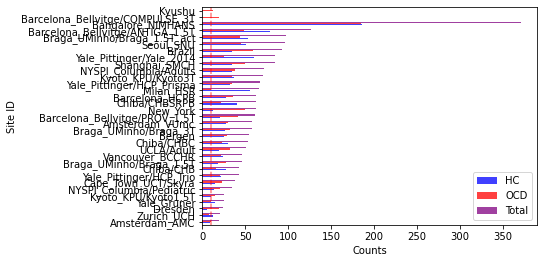

In [43]:
# Plot N subjects that survive QC per site and class

N_threshold = 10
all_sites = np.unique(included_subjects_covariates_df.site_id)

# Show and plot number of classes per site (OCD=1, HC=2)
class_counts_df = included_subjects_covariates_df.groupby(['site_id', 'Diagnosis']).size()
class_counts_df = pd.DataFrame(class_counts_df)
class_counts_df = class_counts_df.reset_index()
class_counts_df.Diagnosis = class_counts_df.Diagnosis.replace({1.0:'OCD', 2.0:'HC'})
class_counts_df = class_counts_df.pivot(index='site_id', columns='Diagnosis')
class_counts_df.columns = class_counts_df.columns.droplevel(0)
class_counts_df.columns.name = None
class_counts_df = class_counts_df.reset_index()
class_counts_df['Total'] = class_counts_df['OCD'] + class_counts_df['HC']
class_counts_df = class_counts_df.sort_values(by='Total')
class_counts_df = class_counts_df.rename(columns={'site_id':'Site ID'})

ax = class_counts_df.plot.barh(color={'OCD':'red', 'HC':'blue', 'Total':'purple'}, x='Site ID', alpha=0.75)
plt.axvline(x = N_threshold, alpha=0.5, linestyle='--', color='red')
ax.set_xlabel("Counts")
plt.show()

In [44]:
# These are sites that do not have at least 10 examples per class after creating EPI coverage template

class_counts_df.loc[np.any(class_counts_df[['HC', 'OCD']].fillna(0) < 10, axis=1)]

,Site ID,HC,OCD,Total
0,Amsterdam_AMC,9.0,10.0,19.0
32,Zurich_UCH,13.0,8.0,21.0
16,Dresden,5.0,19.0,24.0
4,Barcelona_Bellvitge/COMPULSE_3T,NaN,19.0,NaN
19,Kyushu,NaN,13.0,NaN


In [45]:
# Ensure number of excluded and included regions add up to total

assert len(atlas_labels) == len(excluded_atlas_roi_labels ) + len(final_included_atlas_roi_labels)

In [46]:
print("Included ROIs: {}\n".format(len(final_included_atlas_roi_labels)))
print('\n'.join(final_included_atlas_roi_labels))

Included ROIs: 314

Schaefer2018_17Networks_LH_VisCent_ExStr_1
Schaefer2018_17Networks_LH_VisCent_ExStr_2
Schaefer2018_17Networks_LH_VisCent_ExStr_6
Schaefer2018_17Networks_LH_VisCent_ExStr_8
Schaefer2018_17Networks_LH_VisCent_ExStr_9
Schaefer2018_17Networks_LH_VisCent_ExStr_10
Schaefer2018_17Networks_LH_VisCent_ExStr_12
Schaefer2018_17Networks_LH_VisPeri_ExStrSup_1
Schaefer2018_17Networks_LH_VisPeri_ExStrSup_2
Schaefer2018_17Networks_LH_VisPeri_ExStrSup_3
Schaefer2018_17Networks_LH_VisPeri_ExStrSup_4
Schaefer2018_17Networks_LH_VisPeri_ExStrSup_5
Schaefer2018_17Networks_LH_VisPeri_ExStrSup_6
Schaefer2018_17Networks_LH_VisPeri_ExStrSup_7
Schaefer2018_17Networks_LH_VisPeri_ExStrSup_8
Schaefer2018_17Networks_LH_VisPeri_ExStrSup_9
Schaefer2018_17Networks_LH_VisPeri_ExStrSup_10
Schaefer2018_17Networks_LH_VisPeri_ExStrSup_12
Schaefer2018_17Networks_LH_SomMotA_1
Schaefer2018_17Networks_LH_SomMotA_2
Schaefer2018_17Networks_LH_SomMotA_4
Schaefer2018_17Networks_LH_SomMotA_5
Schaefer2018_17Networ

In [47]:
print("Excuded ROIs: {}\n".format(len(excluded_atlas_roi_labels)))
print('\n'.join(excluded_atlas_roi_labels))

Excuded ROIs: 120

Buckner2011_17Networks_1
Buckner2011_17Networks_10
Buckner2011_17Networks_11
Buckner2011_17Networks_12
Buckner2011_17Networks_13
Buckner2011_17Networks_14
Buckner2011_17Networks_15
Buckner2011_17Networks_16
Buckner2011_17Networks_17
Buckner2011_17Networks_2
Buckner2011_17Networks_3
Buckner2011_17Networks_5
Buckner2011_17Networks_6
Buckner2011_17Networks_7
Buckner2011_17Networks_8
Buckner2011_17Networks_9
FreeSurfer_Brain-Stem
FreeSurfer_Left-Accumbens-area
FreeSurfer_Left-Amygdala
FreeSurfer_Left-VentralDC
FreeSurfer_Right-Accumbens-area
FreeSurfer_Right-Amygdala
FreeSurfer_Right-VentralDC
Schaefer2018_17Networks_LH_ContA_IPS_2
Schaefer2018_17Networks_LH_ContB_PFClv_1
Schaefer2018_17Networks_LH_ContB_PFClv_2
Schaefer2018_17Networks_LH_ContB_Temp_1
Schaefer2018_17Networks_LH_ContB_Temp_2
Schaefer2018_17Networks_LH_DefaultA_IPL_2
Schaefer2018_17Networks_LH_DefaultA_PFCm_1
Schaefer2018_17Networks_LH_DefaultA_PFCm_2
Schaefer2018_17Networks_LH_DefaultA_PFCm_5
Schaefer2018

In [48]:
# Check what samples we end up with for CBT classification

np.unique(CBT_covariates_df.loc[(CBT_covariates_df.site_subject_ID.isin(final_included_subject_ids)) &
                                (CBT_covariates_df.Diagnosis == 1.0) & 
                                ~np.isnan(CBT_covariates_df.SevYBOCS_post)].site_id, return_counts=True)

(array(['Barcelona_Bellvitge/ANTIGA_1.5T',
        'Barcelona_Bellvitge/COMPULSE_3T', 'Barcelona_HCPB', 'Bergen',
        'Braga_UMinho/Braga_1.5T_act', 'Chiba/CHB', 'Chiba/CHBC',
        'Chiba/CHBSRPB', 'NYSPI_Columbia/Adults',
        'NYSPI_Columbia/Pediatric', 'UCLA/Adult', 'Zurich_UCH'],
       dtype=object),
 array([39, 18,  6, 27,  5, 13, 19, 12, 32, 16, 32,  5]))

### Extract timeseries for selected atlas and seed ROIs 

In [49]:
# Now check if we can parse all timeseries data (for Schaefer + ICA_AROMA) + Amygdala & vStriatum timeseries

print(np.array(seed_labels)[seed_mask])

corr_matrix_pooled = np.zeros((len(final_included_subject_ids), N_ROIs_pass, N_ROIs_pass))

time_t1 = time()

for i, site_subject_ID in enumerate(final_included_subject_ids):
    
    tmp = included_subjects_derivates_df.loc[included_subjects_derivates_df.site_subject_ID == site_subject_ID]
    subject_id, site_id = tmp.ID.values[0], tmp.site_id.values[0]
    
    subject_dir = os.path.join(MAIN_OUTPUT_DIR, site_id, 'halfpipe', subject_id, 'func')
    subject_filelist = sorted(os.listdir(subject_dir))
    
    atlas_timeseries_path = filter_filelist(subject_filelist, feature_labels[chosen_denoising_id], 
                                            [CONNECTOME_LABELS[chosen_atlas_id], 'timeseries.tsv'])
    
    seed_timeseries_path = os.path.join(SAVE_DIR, site_id, 'seedCorr', 
                                        subject_id + '_feature_seedCorr2_timeseries.csv')
    
    assert (os.path.exists(seed_timeseries_path)) & (len(atlas_timeseries_path) == 1)
    
    atlas_timeseries_path = os.path.join(subject_dir, atlas_timeseries_path[0])
    timeseries_df = pd.read_csv(atlas_timeseries_path, delimiter='\t', header=None)
    
    seed_timeseries_df = pd.read_csv(seed_timeseries_path, delimiter=',', index_col=False)
    seed_timeseries_df = seed_timeseries_df.drop(seed_timeseries_df.columns[0], axis=1)

    merged_timeseries_df = pd.concat([timeseries_df.iloc[:, final_included_atlas_roi_idx ], 
                                      seed_timeseries_df.loc[:, np.array(SEED_LABELS)[seed_mask]]], 
                                     axis=1)
    
    if np.any(merged_timeseries_df.isna()):
        print("NAN DETECTED!")
        break
    
    corr_matrix_pooled[i] = merged_timeseries_df.corr().values
    
time_t2 = time()
print("Finished in {} minutes \n".format((time_t2-time_t1)/60.))

['lamygdala' 'lventralstriatum' 'ramygdala' 'rventralstriatum']
Finished in 3.724813151359558 minutes 



In [50]:
# CHECK: Did we get rid of all NaNs?

assert ~np.any(np.isnan(corr_matrix_pooled))

In [51]:
# CHECK: Is correlation matrix still symmetric?

tril_mask = np.tril(np.ones((N_ROIs_pass, N_ROIs_pass)), k=-1).astype(bool)

tmp_1 = corr_matrix_pooled[..., tril_mask]
tmp_2 = np.transpose(corr_matrix_pooled, (0,2,1))[..., tril_mask]

assert np.all(tmp_1 == tmp_2)

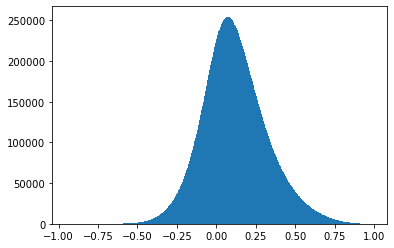

In [52]:
# CHECK: Plot distribution of correlations across all subjects and sites

_ = plt.hist(corr_matrix_pooled[..., tril_mask].flatten(), bins='auto')

Amsterdam_AMC


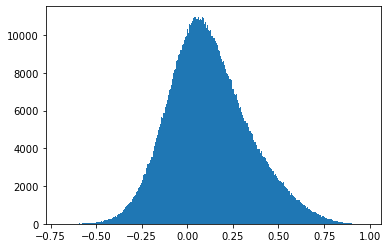

Amsterdam_VUmc


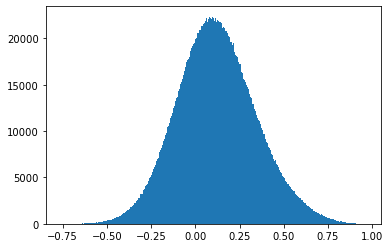

Bangalore_NIMHANS


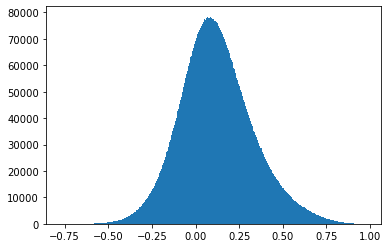

Barcelona_Bellvitge/ANTIGA_1.5T


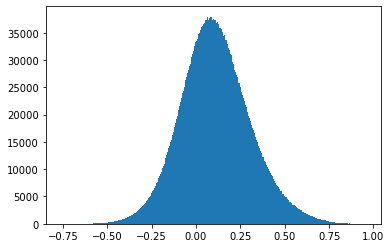

Barcelona_Bellvitge/COMPULSE_3T


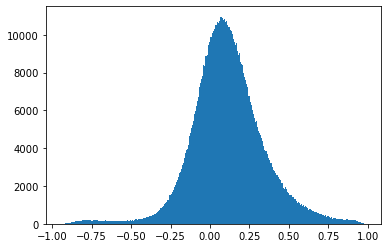

Barcelona_Bellvitge/PROV_1.5T


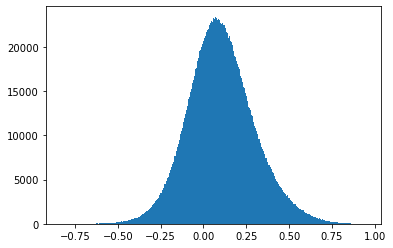

Barcelona_HCPB


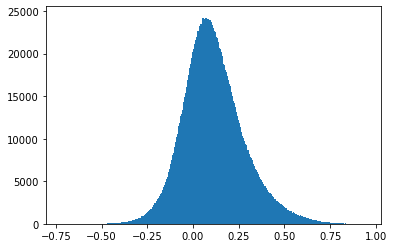

Bergen


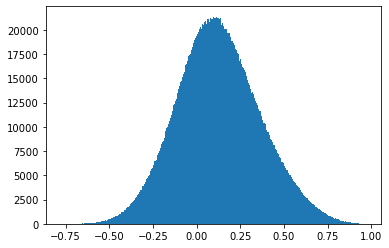

Braga_UMinho/Braga_1.5T


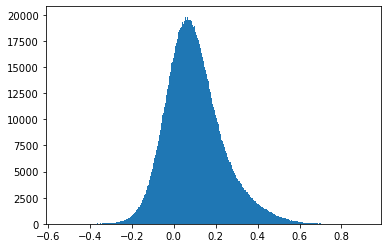

Braga_UMinho/Braga_1.5T_act


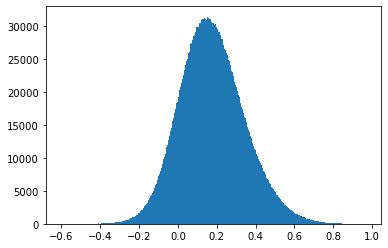

Braga_UMinho/Braga_3T


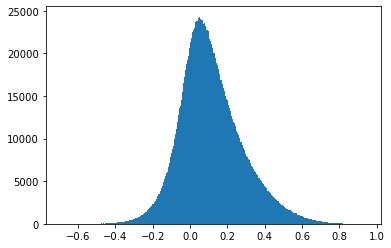

Brazil


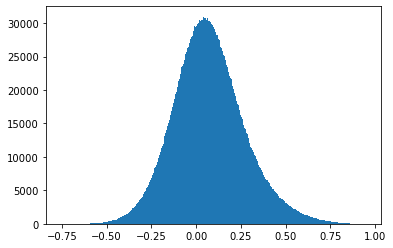

Cape_Town_UCT/Skyra


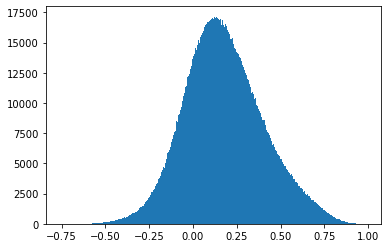

Chiba/CHB


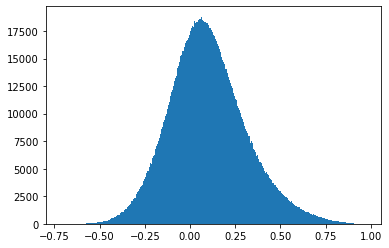

Chiba/CHBC


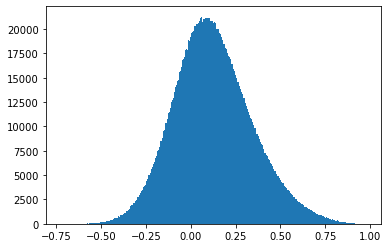

Chiba/CHBSRPB


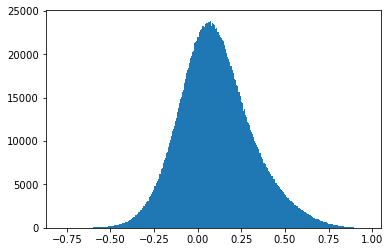

Dresden


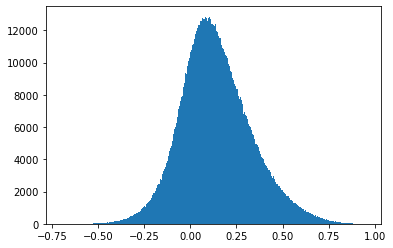

Kyoto_KPU/Kyoto1.5T


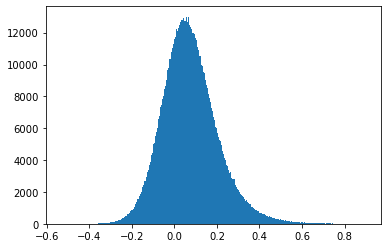

Kyoto_KPU/Kyoto3T


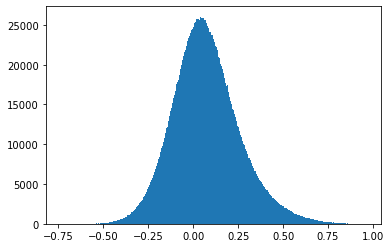

Kyushu


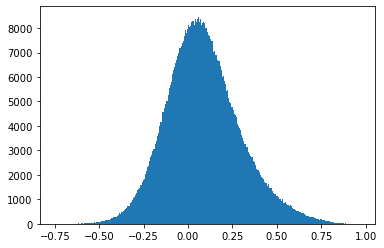

Milan_HSR


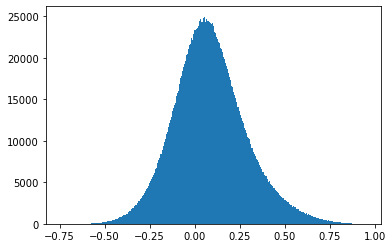

NYSPI_Columbia/Adults


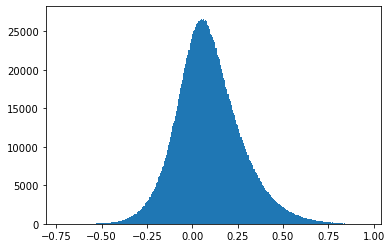

NYSPI_Columbia/Pediatric


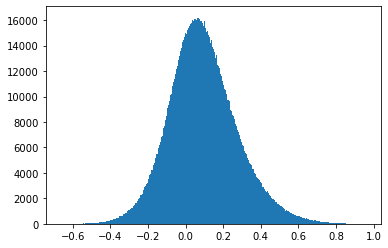

New_York


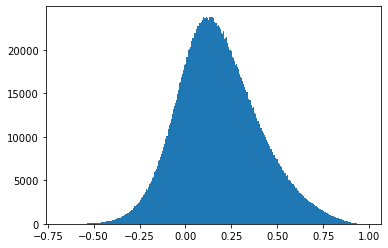

Seoul_SNU


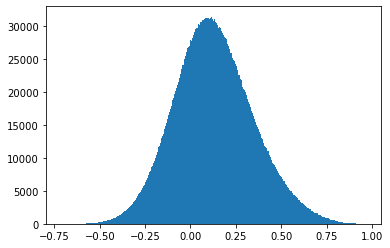

Shanghai_SMCH


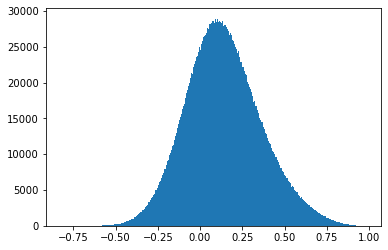

UCLA/Adult


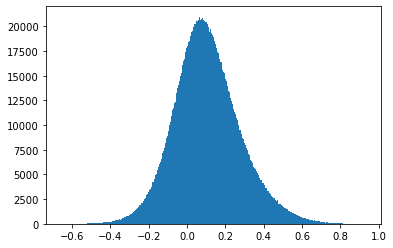

Vancouver_BCCHR


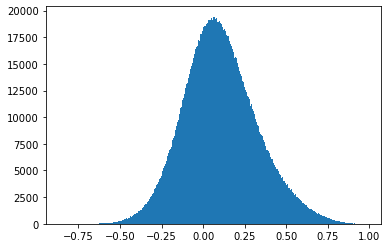

Yale_Gruner


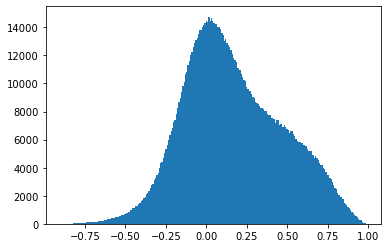

Yale_Pittinger/HCP_Prisma


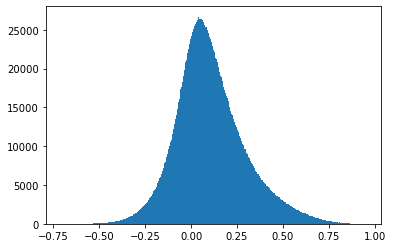

Yale_Pittinger/HCP_Trio


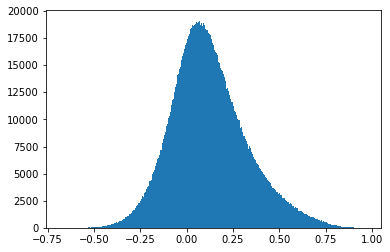

Yale_Pittinger/Yale_2014


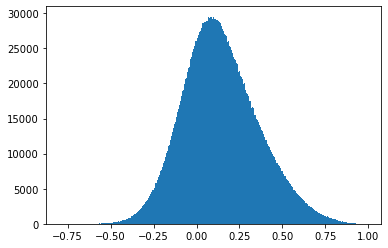

Zurich_UCH


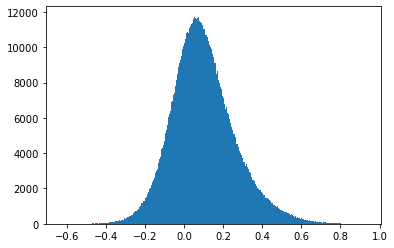

In [53]:
# CHECK: For each included site, plot histogram of corr values

for site in included_sites:
    
    print(site)
    site_mask = (included_subjects_covariates_df.site_id == site).values
    site_corr_mat = corr_matrix_pooled[..., tril_mask][site_mask]
    
    plt.hist(site_corr_mat.flatten(), bins='auto')
    plt.show()

### Create look-up table (LUT) for filtered Schaeffer atlas + included seeds.
#### This includes ROI and network labels and coloring

In [54]:
# Load Schaeffer network LUT with updated "Parcel Names", as apparently, halfpipe was using outdates ones:

# https://github.com/ThomasYeoLab/CBIG/blob/master/stable_projects/brain_parcellation
# /Schaefer2018_LocalGlobal/Parcellations/MNI/fsleyes_lut/Schaefer2018_400Parcels_17Networks_order.lut

# Extract combined atlas labels used by Halfpipe
atlas_labels = np.loadtxt(CONNECTOME_PATHS[chosen_atlas_id].replace('nii.gz', 'txt'), dtype=str)

# Divide combined labels belonging to different atlases
schaeffer_atlas_labels = atlas_labels[:400, 1]
subcort_labels = atlas_labels[400:417, 1]
buckner_atlas_labels = atlas_labels[417:, 1]

# Check whether number or ROIs add up
assert len(atlas_labels) == len(schaeffer_atlas_labels) + len(subcort_labels) + len(buckner_atlas_labels) 

# Extract updated Schaeffer labels from GitHub - see link above
lut_path = '/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Atlases/Schaefer2018_400Parcels_17Networks_order.txt'

# Load updated LUT in dataFrame and add HALFpipe's atlas & network labels as new columns
lut_df = pd.read_csv(lut_path, sep=" ", header=None)
assert lut_df.shape[0] == len(schaeffer_atlas_labels)
lut_df.columns = ['roi_ID', 'R', 'G', 'B', 'Schaeffer_Yeon_labels']
lut_df['halfpipe_labels'] = [s.split('_', 1)[1] for s in schaeffer_atlas_labels]
lut_df['Schaeffer_Yeon_17_networks'] = [s.split('_')[2] for s in lut_df.Schaeffer_Yeon_labels]
lut_df['halfpipe_17_networks'] = [s.split('_')[3] for s in schaeffer_atlas_labels]

# Create average color "B" value per network, add to column
lut_df['B'] = lut_df.groupby('Schaeffer_Yeon_17_networks')['B'].transform('mean')

# Add FreeSurfer subcortical labels and coloring (teal)
R, G, B = (153/256, 255/256, 255/256)
last_row_idx = lut_df.index[-1]
for i, label in enumerate(subcort_labels):
    i_row = last_row_idx + i + 1
    new_row = pd.DataFrame(columns=lut_df.columns.values, 
                           data=[[i_row+1, R, G, B, label, label, 'Sub-Cortical', 'Sub-Cortical']])
    lut_df = pd.concat([lut_df, new_row], ignore_index=True)

# Add 17 Buckner Cerrebellum labels and coloring (brown)
R, G, B = (100/256, 50/256, 0/256)
last_row_idx = lut_df.index[-1]
for i, label in enumerate(buckner_atlas_labels):
    i_row = last_row_idx + i + 1
    new_row = pd.DataFrame(columns=lut_df.columns.values, 
                           data=[[i_row+1, R, G, B, label, label, 'Cerebellum', 'Cerebellum']])
    lut_df = pd.concat([lut_df, new_row], ignore_index=True)
    

# Check if ordering of non-Schaeffer ROIs is still consistent
assert np.all(lut_df[400:].halfpipe_labels.values == np.concatenate([subcort_labels, buckner_atlas_labels])) 

lut_df.tail(15)

,roi_ID,R,G,B,Schaeffer_Yeon_labels,halfpipe_labels,Schaeffer_Yeon_17_networks,halfpipe_17_networks
419,420,0.390625,0.195312,0.0,Buckner2011_17Networks_3,Buckner2011_17Networks_3,Cerebellum,Cerebellum
420,421,0.390625,0.195312,0.0,Buckner2011_17Networks_4,Buckner2011_17Networks_4,Cerebellum,Cerebellum
421,422,0.390625,0.195312,0.0,Buckner2011_17Networks_5,Buckner2011_17Networks_5,Cerebellum,Cerebellum
422,423,0.390625,0.195312,0.0,Buckner2011_17Networks_6,Buckner2011_17Networks_6,Cerebellum,Cerebellum
423,424,0.390625,0.195312,0.0,Buckner2011_17Networks_7,Buckner2011_17Networks_7,Cerebellum,Cerebellum
424,425,0.390625,0.195312,0.0,Buckner2011_17Networks_8,Buckner2011_17Networks_8,Cerebellum,Cerebellum
425,426,0.390625,0.195312,0.0,Buckner2011_17Networks_9,Buckner2011_17Networks_9,Cerebellum,Cerebellum
426,427,0.390625,0.195312,0.0,Buckner2011_17Networks_10,Buckner2011_17Networks_10,Cerebellum,Cerebellum
427,428,0.390625,0.195312,0.0,Buckner2011_17Networks_11,Buckner2011_17Networks_11,Cerebellum,Cerebellum
428,429,0.390625,0.195312,0.0,Buckner2011_17Networks_12,Buckner2011_17Networks_12,Cerebellum,Cerebellum


In [55]:
# Check if final_included_atlas_roi_idx still match with LUT coding

included_atlas_labels_1 = lut_df.iloc[final_included_atlas_roi_idx].halfpipe_labels.values
included_atlas_labels_2 = np.array(final_included_atlas_roi_labels.copy())
included_atlas_labels_2[final_included_atlas_roi_idx < 400] = [roi.split('_', 1)[1] 
                                                               for roi in included_atlas_labels_2[
                                                                   final_included_atlas_roi_idx < 400]
                                                                                                  ]

assert np.all(included_atlas_labels_1 == included_atlas_labels_2) # Good!

In [56]:
# Extract updated Schaeffer labels from LUT

renamed_included_atlas_roi_labels = lut_df.iloc[final_included_atlas_roi_idx].Schaeffer_Yeon_labels.values

# Print updated labels
for a in list(zip(final_included_atlas_roi_labels, renamed_included_atlas_roi_labels)):
    print(a)

('Schaefer2018_17Networks_LH_VisCent_ExStr_1', '17Networks_LH_VisCent_ExStr_1')
('Schaefer2018_17Networks_LH_VisCent_ExStr_2', '17Networks_LH_VisCent_ExStr_2')
('Schaefer2018_17Networks_LH_VisCent_ExStr_6', '17Networks_LH_VisCent_ExStr_6')
('Schaefer2018_17Networks_LH_VisCent_ExStr_8', '17Networks_LH_VisCent_ExStr_7')
('Schaefer2018_17Networks_LH_VisCent_ExStr_9', '17Networks_LH_VisCent_ExStr_8')
('Schaefer2018_17Networks_LH_VisCent_ExStr_10', '17Networks_LH_VisCent_ExStr_9')
('Schaefer2018_17Networks_LH_VisCent_ExStr_12', '17Networks_LH_VisCent_ExStr_11')
('Schaefer2018_17Networks_LH_VisPeri_ExStrSup_1', '17Networks_LH_VisPeri_ExStrInf_1')
('Schaefer2018_17Networks_LH_VisPeri_ExStrSup_2', '17Networks_LH_VisPeri_ExStrInf_2')
('Schaefer2018_17Networks_LH_VisPeri_ExStrSup_3', '17Networks_LH_VisPeri_ExStrInf_3')
('Schaefer2018_17Networks_LH_VisPeri_ExStrSup_4', '17Networks_LH_VisPeri_ExStrInf_4')
('Schaefer2018_17Networks_LH_VisPeri_ExStrSup_5', '17Networks_LH_VisPeri_ExStrInf_5')
('Schae

In [57]:
# Extract labels for networks corresponding to included ROIs

included_atlas_network_labels = lut_df.iloc[final_included_atlas_roi_idx].Schaeffer_Yeon_17_networks.values

print(np.unique(included_atlas_network_labels), len(np.unique(included_atlas_network_labels)))

['Cerebellum' 'ContA' 'ContB' 'ContC' 'DefaultA' 'DefaultB' 'DefaultC'
 'DorsAttnA' 'DorsAttnB' 'LimbicA' 'SalVentAttnA' 'SalVentAttnB' 'SomMotA'
 'SomMotB' 'Sub-Cortical' 'TempPar' 'VisCent' 'VisPeri'] 18


In [58]:
# Add network labels for additionally included seeds manually

included_seed_roi_labels = np.array(seed_labels)[seed_mask]
included_seed_networks_labels = np.array(['Sub-Cortical', 'Sub-Cortical', 'Sub-Cortical', 'Sub-Cortical'])

print(included_seed_roi_labels)

['lamygdala' 'lventralstriatum' 'ramygdala' 'rventralstriatum']


In [59]:
# Add seeds labels and coloring to LUT dataFrame (use same color for network as FreeSurfer-Subcortical)

R, G, B = (153/256, 255/256, 255/256)
last_row_idx = lut_df.index[-1]

for i, (seed, network) in enumerate(zip(included_seed_roi_labels, included_seed_networks_labels)):
    
    i_row = last_row_idx + i + 1
    new_row = pd.DataFrame(columns=lut_df.columns.values, 
                           data=[[i_row+1, R, G, B, seed, seed, network, network]])
    lut_df = pd.concat([lut_df, new_row], ignore_index=True)
    
lut_df.tail(5)

,roi_ID,R,G,B,Schaeffer_Yeon_labels,halfpipe_labels,Schaeffer_Yeon_17_networks,halfpipe_17_networks
433,434,0.390625,0.195312,0.000000,Buckner2011_17Networks_17,Buckner2011_17Networks_17,Cerebellum,Cerebellum
434,435,0.597656,0.996094,0.996094,lamygdala,lamygdala,Sub-Cortical,Sub-Cortical
435,436,0.597656,0.996094,0.996094,lventralstriatum,lventralstriatum,Sub-Cortical,Sub-Cortical
436,437,0.597656,0.996094,0.996094,ramygdala,ramygdala,Sub-Cortical,Sub-Cortical
437,438,0.597656,0.996094,0.996094,rventralstriatum,rventralstriatum,Sub-Cortical,Sub-Cortical


In [60]:
assert N_ROIs_pass == len(renamed_included_atlas_roi_labels) + len(included_seed_roi_labels)
assert N_ROIs_pass == len(included_atlas_network_labels) + len(included_seed_networks_labels)

In [61]:
# These are the final, updated Schaeffer + seed ROI & network labels for our included regions

included_roi_labels = np.concatenate([renamed_included_atlas_roi_labels, included_seed_roi_labels])
included_network_labels = np.concatenate([included_atlas_network_labels, included_seed_networks_labels])

In [62]:
for r, n in zip(included_roi_labels, included_network_labels):
    print(r,n)

17Networks_LH_VisCent_ExStr_1 VisCent
17Networks_LH_VisCent_ExStr_2 VisCent
17Networks_LH_VisCent_ExStr_6 VisCent
17Networks_LH_VisCent_ExStr_7 VisCent
17Networks_LH_VisCent_ExStr_8 VisCent
17Networks_LH_VisCent_ExStr_9 VisCent
17Networks_LH_VisCent_ExStr_11 VisCent
17Networks_LH_VisPeri_ExStrInf_1 VisPeri
17Networks_LH_VisPeri_ExStrInf_2 VisPeri
17Networks_LH_VisPeri_ExStrInf_3 VisPeri
17Networks_LH_VisPeri_ExStrInf_4 VisPeri
17Networks_LH_VisPeri_ExStrInf_5 VisPeri
17Networks_LH_VisPeri_StriCal_1 VisPeri
17Networks_LH_VisPeri_StriCal_2 VisPeri
17Networks_LH_VisPeri_ExStrSup_1 VisPeri
17Networks_LH_VisPeri_ExStrSup_2 VisPeri
17Networks_LH_VisPeri_ExStrSup_3 VisPeri
17Networks_LH_VisPeri_ExStrSup_5 VisPeri
17Networks_LH_SomMotA_1 SomMotA
17Networks_LH_SomMotA_2 SomMotA
17Networks_LH_SomMotA_4 SomMotA
17Networks_LH_SomMotA_5 SomMotA
17Networks_LH_SomMotA_6 SomMotA
17Networks_LH_SomMotA_7 SomMotA
17Networks_LH_SomMotA_8 SomMotA
17Networks_LH_SomMotA_9 SomMotA
17Networks_LH_SomMotA_10 Som

/data/wbbruin/Desktop/ME_RSFMRI_TEDANA/atlases_and_seeds/L_amygdala_seed_2009.nii.gz
/data/wbbruin/Desktop/ME_RSFMRI_TEDANA/atlases_and_seeds/L_ventralstriatum_seed_2009.nii.gz
/data/wbbruin/Desktop/ME_RSFMRI_TEDANA/atlases_and_seeds/R_amygdala_seed_2009.nii.gz
/data/wbbruin/Desktop/ME_RSFMRI_TEDANA/atlases_and_seeds/R_ventralstriatum_seed_2009.nii.gz


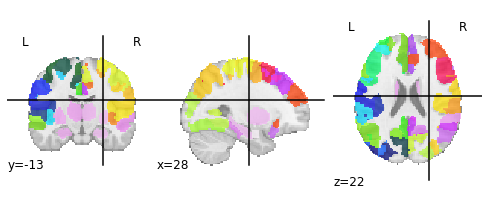

In [71]:
# Create NIFTI image of filtered Schaeffer atlas + included seeds:

schaeffer_atlas_path = CONNECTOME_PATHS[chosen_atlas_id]
atlas_img = nib.load(schaeffer_atlas_path)
atlas_data = atlas_img.get_fdata().astype(int)

filtered_atlas_data = atlas_data.copy()
filtered_atlas_data[:] = 0

# Iterate over included atlas ROI labels and add label IDs to filtered atlas

for included_roi in renamed_included_atlas_roi_labels:
    
    lut_row = lut_df.loc[lut_df.Schaeffer_Yeon_labels == included_roi]
    assert len(lut_row) == 1 
    roi_label_ID = lut_row.roi_ID.values[0]
    
    tmp_mask = atlas_data == roi_label_ID
    filtered_atlas_data[tmp_mask] = roi_label_ID

# Now add seeds of interest that were not included in atlas

for seed in included_seed_roi_labels:
    seed_mask_ = [seed in label for label in SEED_LABELS]
    seed_nifti_paths = SEED_PATHS[seed_mask_]

    assert len(seed_nifti_paths) == 1

    path = seed_nifti_paths[0]
    print(path)

    seed_img = nib.load(path)
    assert np.all(atlas_img.affine == seed_img.affine)

    seed_data = seed_img.get_fdata()
    seed_label_ID = lut_df.loc[lut_df.Schaeffer_Yeon_labels == seed].roi_ID.values[0]
    filtered_atlas_data[seed_data == 1] = seed_label_ID
    

filtered_atlas_img = nib.Nifti1Image(filtered_atlas_data, atlas_img.affine, atlas_img.header)

assert len(np.unique(filtered_atlas_data)) == N_ROIs_pass + 1 # Add background coded as 0

plotting.plot_roi(filtered_atlas_img)
plt.show()

In [72]:
# We now want to sort our all features based on these network occurences:

network_ordering_dict = {
                            'VisCent' : 1,
                            'VisPeri' : 2,
                            'SomMotA' : 3,
                            'SomMotB' : 4,
                            'DorsAttnA' : 5,
                            'DorsAttnB' : 6,
                            'SalVentAttnA' : 7,
                            'SalVentAttnB' : 8,
                            'LimbicA' : 9,
                            'LimbicB' : 10,
                            'ContA' : 11,
                            'ContB' : 12,
                            'ContC' : 13,
                            'DefaultA' : 14,
                            'DefaultB' : 15,
                            'DefaultC' : 16,
                            'TempPar' : 17,
                            'Sub-Cortical' : 18,
                            'Cerebellum' : 19
                        }


network_sorted_idx = np.argsort([network_ordering_dict[l] for l in included_network_labels])

sorted_roi_labels = included_roi_labels[network_sorted_idx]
sorted_network_labels = included_network_labels[network_sorted_idx]

In [73]:
# Reorder correlation matrix using above network_sorted_idx

sorted_CC_matrix = np.empty_like(corr_matrix_pooled) # (N_subjects, N_ROIs, N_ROIs)
N_subjects = corr_matrix_pooled.shape[0]

for i_subject in range(N_subjects):
    for ei, i in enumerate(network_sorted_idx):
        c = corr_matrix_pooled[i_subject, i]
        c = c[network_sorted_idx]
        sorted_CC_matrix[i_subject, ei] = c

In [74]:
# If sorting was succesful, all diagonals across subjects should be 1

i, j = np.diag_indices(N_ROIs_pass)

np.unique(sorted_CC_matrix[:, i, j])

array([1.])

In [75]:
sorted_unique_network_labels = []

for label in network_ordering_dict.keys():
    if label not in sorted_network_labels:
        continue
    else:
        sorted_unique_network_labels.append(label)
        
N_included_networks = len(sorted_unique_network_labels)

print(sorted_unique_network_labels)

['VisCent', 'VisPeri', 'SomMotA', 'SomMotB', 'DorsAttnA', 'DorsAttnB', 'SalVentAttnA', 'SalVentAttnB', 'LimbicA', 'ContA', 'ContB', 'ContC', 'DefaultA', 'DefaultB', 'DefaultC', 'TempPar', 'Sub-Cortical', 'Cerebellum']


In [76]:
# Fisher Z-transform sorted_CC_matrix before taking averages across networks

# Create masks for lower and upper triangular of correlation matrix. Skip diagonal (auto) correlations.
tril_mask = np.tril(np.ones((N_ROIs_pass, N_ROIs_pass)), k=-1).astype(bool)

# Take lower triangular of FC matrix
vec = sorted_CC_matrix[..., tril_mask]

# Fisher Z-transform correlations:
vec = np.arctanh(vec)

# Transform these values back to matrix
Z_CC_matrix = np.zeros_like(sorted_CC_matrix)
Z_CC_matrix[..., tril_mask] = vec

Z_CC_matrix += np.transpose(Z_CC_matrix, axes=(0,2,1))

# Fill diagonal with 1 again, we will NOT use these
i, j = np.diag_indices(N_ROIs_pass)
Z_CC_matrix[:, i, j] = 1

In [77]:
# Is Z_CC_matrix still symmetric?

tril_mask = np.tril(np.ones((N_ROIs_pass, N_ROIs_pass)), k=-1).astype(bool)

tmp_1 = Z_CC_matrix[..., tril_mask]
tmp_2 = np.transpose(Z_CC_matrix, (0,2,1))[..., tril_mask]

assert np.all(tmp_1 == tmp_2)

In [78]:
Z_CC_matrix.min(), Z_CC_matrix.max()

(-1.7602020636513347, 2.5371584000790963)

In [79]:
# Extract within network correlations

within_network_correlations = np.zeros((N_subjects, N_included_networks))
within_network_correlations_labels = np.array(sorted_unique_network_labels)
keep_network_mask = np.ones((N_included_networks)).astype(bool)

for i, network_label in enumerate(sorted_unique_network_labels):

    network_mask = network_label == sorted_network_labels
    N_ROIs_in_network =  sum(network_mask)
    print(i, network_label, N_ROIs_in_network)
    
    # Get rid of within network correlations with 1 ROI, these become NaNs
    if N_ROIs_in_network <= 1:
        keep_network_mask[i] = False
    
    # Extract correlations for ROIs from given network with all other ROIs, for all subjects
    tmp_corrs = Z_CC_matrix[:, network_mask]
    
    # Now only take within network correlations
    tmp_corrs = tmp_corrs[:, :, network_mask]
    
    # Take lower triangular
    tril_mask = np.tril(np.ones((N_ROIs_in_network, N_ROIs_in_network)), k=-1).astype(bool)
    
    # Average lower triangular of within network correlations
    within_network_correlations[:, i] = np.mean(tmp_corrs[..., tril_mask], axis=1)
    
within_network_correlations = within_network_correlations[:, keep_network_mask]
within_network_correlations_labels = within_network_correlations_labels[keep_network_mask]

0 VisCent 15
1 VisPeri 21
2 SomMotA 28
3 SomMotB 31
4 DorsAttnA 19
5 DorsAttnB 20
6 SalVentAttnA 32
7 SalVentAttnB 16
8 LimbicA 1
9 ContA 23


/data_local/softwares/anaconda3/envs/ENIGMA_OCD_RSFMRI/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data_local/softwares/anaconda3/envs/ENIGMA_OCD_RSFMRI/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


10 ContB 14
11 ContC 12
12 DefaultA 26
13 DefaultB 20
14 DefaultC 10
15 TempPar 15
16 Sub-Cortical 14
17 Cerebellum 1


In [80]:
# Extract between network correlations

between_network_correlations = np.zeros((N_subjects, N_included_networks, N_included_networks))
between_network_correlations_labels = np.array(sorted_unique_network_labels)

for i, network_label in enumerate(sorted_unique_network_labels):

    network_mask = network_label == sorted_network_labels
    N_ROIs_in_network =  sum(network_mask)
    print(i, network_label, N_ROIs_in_network)
    
    # Extract correlations for ROIs from given network with all other ROIs, for all subjects
    tmp_corrs = Z_CC_matrix[:, network_mask]
    
    for j, network_label_ in enumerate(sorted_unique_network_labels):
        
        network_mask_ = network_label_ == sorted_network_labels
        
        # Now extract correlation between given network and all other networks 
        between_network_corr = tmp_corrs[:, :, network_mask_].mean(axis=1).mean(axis=1)
        between_network_correlations[:, i, j] = between_network_corr

0 VisCent 15
1 VisPeri 21
2 SomMotA 28
3 SomMotB 31
4 DorsAttnA 19
5 DorsAttnB 20
6 SalVentAttnA 32
7 SalVentAttnB 16
8 LimbicA 1
9 ContA 23
10 ContB 14
11 ContC 12
12 DefaultA 26
13 DefaultB 20
14 DefaultC 10
15 TempPar 15
16 Sub-Cortical 14
17 Cerebellum 1


In [81]:
# Now extract ROI-wise fALFF & reHo
# Note that the filtered atlas we use still has old indexing (not sorted on network labels yet)!

def extract_feature_per_ROI(site_subject_ID, img_suffix, mask_suffix, atlas_img, derivates_df):
    
    tmp = derivates_df.loc[derivates_df.site_subject_ID == site_subject_ID]
    subject_id, site_id = tmp.ID.values[0], tmp.site_id.values[0]
    subject_dir = os.path.join(MAIN_OUTPUT_DIR, site_id, 'halfpipe', subject_id, 'func')
    subject_filelist = sorted(os.listdir(subject_dir))
    
    img_path = filter_filelist(subject_filelist, img_suffix, 'nii.gz')
    assert(len(img_path) == 1)
    img_mask_path = filter_filelist(subject_filelist, mask_suffix, 'nii.gz')
    assert(len(img_mask_path) == 1)
    
    img = nib.load(os.path.join(subject_dir, img_path[0]))
    mask_img = nib.load(os.path.join(subject_dir, img_mask_path[0]))
    
    # We use the NiftiLabelsMasker to extract average reHo per ROI
    labels_masker = NiftiLabelsMasker(labels_img=atlas_img, mask_img=mask_img, 
                                      background_label=0, standardize=False, verbose=0)
    
    return labels_masker.fit_transform(img)
    

In [82]:
# Extract regional reHo using filtered_atlas_img that has NOT been sorted on network occurences yet

reho_prefix = parse_feature_labels('reHo')[chosen_denoising_id]
print(reho_prefix)

reHo_per_ROI = Parallel(n_jobs=20, verbose=1)(delayed(extract_feature_per_ROI)
                                              (site_subject_ID, 
                                               reho_prefix+'reho', 
                                               reho_prefix+'mask',
                                               filtered_atlas_img, included_subjects_derivates_df)
                                               for site_subject_ID in final_included_subject_ids)

reHo_per_ROI = np.array(reHo_per_ROI).squeeze()
reHo_per_ROI.shape

reHo2_


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   10.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   17.0s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   25.8s
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   36.6s
[Parallel(n_jobs=20)]: Done 2148 out of 2148 | elapsed:   44.3s finished


(2148, 318)

In [83]:
# Extract regional fALFF  using filtered_atlas_img that has NOT been sorted on network occurences yet

falff_prefix = parse_feature_labels('fALFF')[chosen_denoising_id]
print(falff_prefix)

fALFF_per_ROI = Parallel(n_jobs=20, verbose=1)(delayed(extract_feature_per_ROI)
                                              (site_subject_ID, 
                                               falff_prefix+'falff', 
                                               falff_prefix+'mask',
                                               filtered_atlas_img, included_subjects_derivates_df)
                                               for site_subject_ID in final_included_subject_ids)

fALFF_per_ROI = np.array(fALFF_per_ROI).squeeze()
fALFF_per_ROI.shape

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


fALFF2_


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    8.0s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   14.6s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   23.5s
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   34.1s
[Parallel(n_jobs=20)]: Done 2148 out of 2148 | elapsed:   41.7s finished


(2148, 318)

In [84]:
# Now sort fALFF & reHO on network occurences

sorted_reHo_per_ROI = reHo_per_ROI[:, network_sorted_idx]
sorted_fALFF_per_ROI = fALFF_per_ROI[:, network_sorted_idx]

In [85]:
print(sorted_fALFF_per_ROI.min(), sorted_fALFF_per_ROI.max())

-5.134157657623291 5.390778320527733


In [86]:
print(sorted_reHo_per_ROI.min(), sorted_reHo_per_ROI.max())

-3.3230038681054084 5.194765826580683


In [87]:
# Extract fALFF & reHo per network by averaging over given network ROIs

reHo_per_network = np.zeros((N_subjects, N_included_networks))
fALFF_per_network = np.zeros((N_subjects, N_included_networks))

for i, network_label in enumerate(sorted_unique_network_labels):
    
    network_mask = network_label == sorted_network_labels
    N_ROIs_in_network =  sum(network_mask)
    print(i, network_label, N_ROIs_in_network)
    
    reHo_per_network[:, i] = sorted_reHo_per_ROI[:, network_mask].mean(axis=1)
    fALFF_per_network[:, i] = sorted_fALFF_per_ROI[:, network_mask].mean(axis=1)

0 VisCent 15
1 VisPeri 21
2 SomMotA 28
3 SomMotB 31
4 DorsAttnA 19
5 DorsAttnB 20
6 SalVentAttnA 32
7 SalVentAttnB 16
8 LimbicA 1
9 ContA 23
10 ContB 14
11 ContC 12
12 DefaultA 26
13 DefaultB 20
14 DefaultC 10
15 TempPar 15
16 Sub-Cortical 14
17 Cerebellum 1


In [88]:
print(reHo_per_network.min(), reHo_per_network.max())

-1.8951213359832764 2.182867317721731


In [89]:
print(fALFF_per_network.min(), fALFF_per_network.max())

-2.4365577697753906 3.6206452442424157


In [90]:
included_subjects_derivates_df.shape[0] == N_subjects

True

In [91]:
between_network_correlations_labels, len(between_network_correlations_labels)

(array(['VisCent', 'VisPeri', 'SomMotA', 'SomMotB', 'DorsAttnA',
        'DorsAttnB', 'SalVentAttnA', 'SalVentAttnB', 'LimbicA', 'ContA',
        'ContB', 'ContC', 'DefaultA', 'DefaultB', 'DefaultC', 'TempPar',
        'Sub-Cortical', 'Cerebellum'], dtype='<U12'),
 18)

### Store extracted features and sample info. 
### Note: all features (reho+falff+FC) have been sorted on network occurences already

In [92]:
# !!! Store copy of all pooled data needed for classification !!!

pooled_data_main_dir = '/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Pooled_Data'
pooled_data_save_dir = os.path.join(pooled_data_main_dir, datetime.date.today().strftime("%d_%m_%Y"))
pooled_data_save_path = os.path.join(pooled_data_save_dir, 'pooled_data.npz')

if not os.path.exists(pooled_data_save_path):
    
    N_subjects = included_subjects_derivates_df.shape[0]
    N_sites = len(included_subjects_derivates_df.site_id.unique())
    
    print("Storing pooled data for {} subjects from {} sites...".format(N_subjects, N_sites))
    ensure_folder(pooled_data_save_dir)
    
    np.savez(pooled_data_save_path, 
             
             # Subject IDs
             included_subject_ids=final_included_subject_ids,
             
             # ROI and corresponding network labels
             roi_labels=sorted_roi_labels,
             network_labels=sorted_network_labels,
             
             # Dictionary for applied network ordering of features
             network_ordering_dict=network_ordering_dict,
             
             # Local activity measures averaged across ROIs and per network
             fALFF_per_ROI=sorted_fALFF_per_ROI,
             fALFF_per_network=fALFF_per_network,
             reHo_per_ROI=sorted_reHo_per_ROI,
             reHo_per_network=reHo_per_network,
             
             # Fisher-Z transformed correlation matrix of pairwise ROI-to-ROI FC
             CC_matrix=Z_CC_matrix,
             
             # Averaged within network correlations (using Fisher-Z transformed ROI-to-ROI FC)
             within_network_correlations=within_network_correlations,
             within_network_correlations_labels=within_network_correlations_labels,
             
             # Averaged between network correlations (using Fisher-Z transformed ROI-to-ROI FC)
             between_network_correlations=between_network_correlations,
             between_network_correlations_labels=between_network_correlations_labels,

            )
    
    
    # Store image of included Combined-Schaeffer ROIs + manually added Seeds
    nib.save(filtered_atlas_img, os.path.join(pooled_data_save_dir, 'included_regions_atlas.nii.gz'))
    
    # Store spreadsheets of included subject covariates and rsfMRI derivates info
    included_subjects_derivates_df.to_csv(os.path.join(pooled_data_save_dir, 
                                                       'included_subjects_derivates.csv'))
    included_subjects_covariates_df.to_csv(os.path.join(pooled_data_save_dir, 
                                                       'included_subjects_covariates.csv'))
    included_patients_CBT_covariates_df.to_csv(os.path.join(pooled_data_save_dir, 
                                                       'included_patients_CBT_covariates.csv'))
    
    # Save updated LUT for network/color label info of Combined-Schaeffer ROIs + manually added Seeds
    lut_df.to_csv(os.path.join(pooled_data_save_dir, 'Schaefer2018_400Parcels_17Networks_LUT.csv'), index=False)
    
    print("Done!")

Storing pooled data for 2148 subjects from 33 sites...
Done!


In [ ]:
# # Code below can be used to extract voxelwise fALFF and reHo

# def extract_local_measures(site_subject_ID, img_suffix, mask_suffix, derivates_df):
    
#     tmp = derivates_df.loc[derivates_df.site_subject_ID == site_subject_ID]
#     subject_id, site_id = tmp.ID.values[0], tmp.site_id.values[0]
#     subject_dir = os.path.join(MAIN_OUTPUT_DIR, site_id, 'halfpipe', subject_id, 'func')
#     subject_filelist = sorted(os.listdir(subject_dir))
    
#     img_path = filter_filelist(subject_filelist, img_suffix, 'nii.gz')
#     assert(len(img_path) == 1)
#     img_mask_path = filter_filelist(subject_filelist, mask_suffix, 'nii.gz')
#     assert(len(img_mask_path) == 1)
    
#     img = nib.load(os.path.join(subject_dir, img_path[0]))
#     mask_img = nib.load(os.path.join(subject_dir, img_mask_path[0]))
    
#     img_data = img.get_fdata()
#     bool_mask_data = mask_img.get_fdata().astype(bool)
    
#     img_data[~bool_mask_data] = 0
    
#     return img_data
    
    
# reHo = Parallel(n_jobs=20, verbose=1)(delayed(extract_local_measures)
#                                               (site_subject_ID, 'reHo2_reho', 'reHo2_mask',
#                                                included_subjects_derivates_df)
#                                                for site_subject_ID in included_subject_ids)

# reHo = np.array(reHo).squeeze()
# reHo.shape

# reHo_group_mask = np.mean((reHo != 0).astype(int), axis=0)
# reHo_group_mask = reHo_group_mask > 0.9

# bool_reHo_group_mask = reHo_group_mask.astype(bool)
# bool_reHo_group_mask.shape

# voxelwise_reHo = reHo[:, bool_reHo_group_mask]
# voxelwise_reHo.shape